In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    **kwargs,
)

files = (
    [] + 
    # file_fn(FILTER="F380M")[:1] +
    file_fn(FILTER="F430M")[:1]
    # file_fn(FILTER="F480M")[:1]
)

# files = files[:2]

# files = file_fn()

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



1
  TARGPROP: HD-41094
  FILTER: F430M
  NINTS: 905
  NGROUPS: 20
  OBSERVTN: 001
  NCHUNKS: 1


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
import jax.numpy as np
from amigo.core import AmigoModel
from amigo.optics import AMIOptics
from amigo.detectors import LinearDetectorModel, ReadModel, SimpleRamp
from amigo.files import get_exposures, initialise_params

optics = AMIOptics()
detector = LinearDetectorModel()
ramp_model = SimpleRamp()
read_model = ReadModel()

# Prep the model
exposures = get_exposures(files)
params = initialise_params(exposures, optics)
model = AmigoModel(files, params, optics=optics)

In [5]:
# from amigo.non_linear import PolyNonLin

# polyEDM = PolyNonLin().set('coeffs', np.load('files/poly_coeffs.npy'))
# model = model.set("ramp", polyEDM)

### Now we need to make some fake binary stars.

In [6]:
from amigo.core import Exposure

class FakeExposure(Exposure):

    def __init__(self, exp, data, var, key):
        self.data = data
        self.variance = variance
        self.support = exp.support
        self.opd = exp.opd
        self.key = key
        self.nints = exp.nints
        self.ngroups = exp.ngroups
        self.nslopes = exp.nslopes
        self.filter = exp.filter
        self.star = exp.star
        self.zero_point = exp.zero_point

In [7]:
import jax.random as jr
import equinox as eqx
import dLux as dl
import dLux.utils as dlu
from amigo.modelling import planck, model_ramp
from jax.scipy.signal import convolve
from jax import vmap

diff_lim = dlu.rad2arcsec(4e-6 / 6.6)

# Separations
# seps = np.linspace(0.1, 1, 10) * diff_lim
# seps = np.array([0.1, 0.3, 0.5]) * diff_lim
# seps = np.array([0.01, 0.05, 0.1]) * diff_lim
# seps = np.array([0.001, 0.01, 0.1]) * diff_lim
seps = np.array([0.05, 0.1, 0.2, 0.5]) * diff_lim
pos_angle = 0

# Contrasts
# log_contrasts = np.array([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0])
# log_contrasts = np.array([-4.0, -2.0, 0.0])
# log_contrasts = np.array([-8., -6., -4.0])
log_contrasts = np.array([-8.0, -6.0, -4.0, -2.0])
mean_flux = 1

true_flux = 10**6.15

filter = "F430M"
star = "HD-41094"
exp = exposures[0]

idx = 0
images = []
new_exposures = []
for sep in seps:

    position = np.zeros(2)
    r, phi = dlu.arcsec2rad(sep) / 2, dlu.deg2rad(pos_angle)
    sep_vec = np.array([r * np.sin(phi), r * np.cos(phi)])
    positions = np.array([position + sep_vec, position - sep_vec])

    psfs = []
    for position in positions:

        # Get wavelengths and weights
        wavels, filt_weights = model.filters[filter]
        weights = filt_weights * planck(wavels, model.Teffs[star])
        weights = weights / weights.sum()

        # TODO: Jit this sub-function for improved compile times
        prop_fn = eqx.filter_jit(optics.propagate)
        wfs = prop_fn(wavels, position, weights, return_wf=True)

        # PSF is still unitary here
        # TODO: Jit this sub-function for improved compile times
        apply_det = eqx.filter_jit(model.detector.apply)
        psf = apply_det(dl.PSF(wfs.psf.sum(0), wfs.pixel_scale.mean(0)))
        psfs.append(psf.data)
    psfs = np.array(psfs)

    for cont in log_contrasts:
        contrast = 10**cont
        fluxes = np.array([contrast * mean_flux, mean_flux]) / (1 + contrast)
        combined_psf = (psfs * fluxes[:, None, None]).sum(0)

        # Get the slopes
        psf = dlu.downsample(combined_psf * true_flux, 4, mean=False)
        ramp = model_ramp(psf, exp.ngroups)
        slopes = np.diff(ramp, axis=0)

        # Get the variance and add noise
        variance = slopes / exp.nints
        fake_data = slopes + (
            np.sqrt(variance) * jr.normal(jr.PRNGKey(0), slopes.shape)
        )

        # Apply the IPC
        reads = vmap(lambda x: convolve(x, model.ipc, mode="same"))(fake_data)

        # Create the new exposure
        new_exposures.append(FakeExposure(exp, reads, variance, exp.key + f"_{idx}"))
        idx += 1

In [8]:
params = initialise_params(new_exposures, optics)
model = AmigoModel(files, params, optics=optics)
model = model.set("ramp", None)

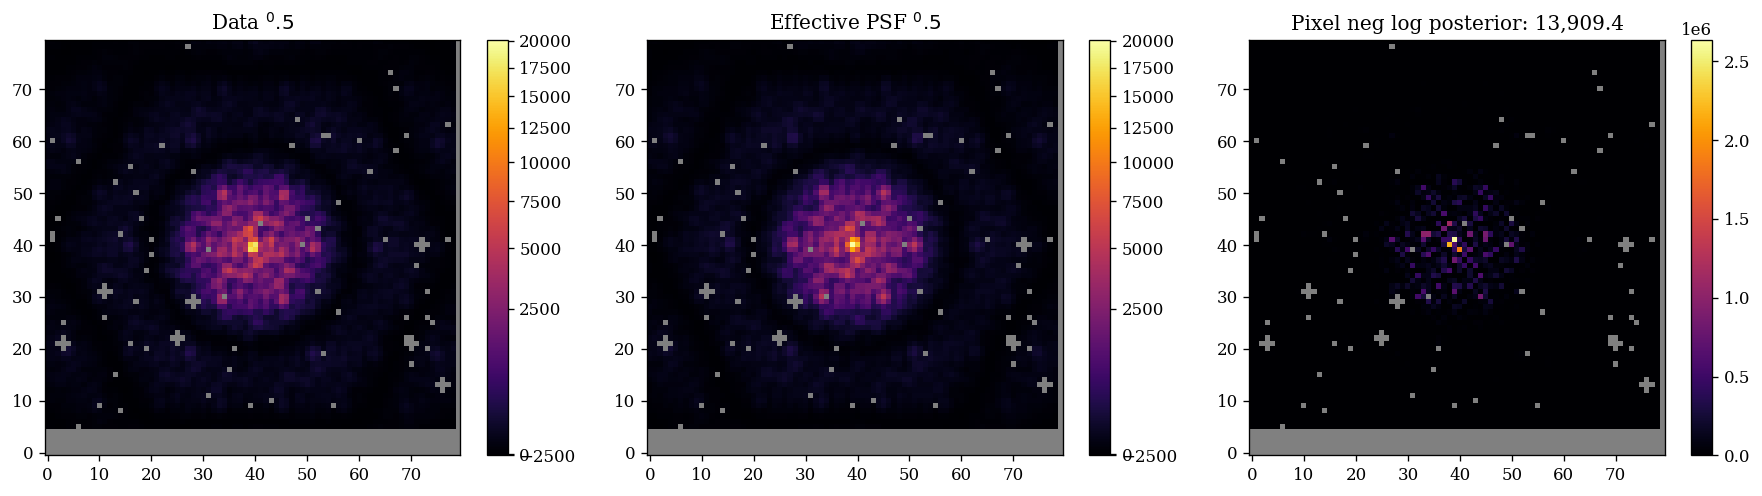

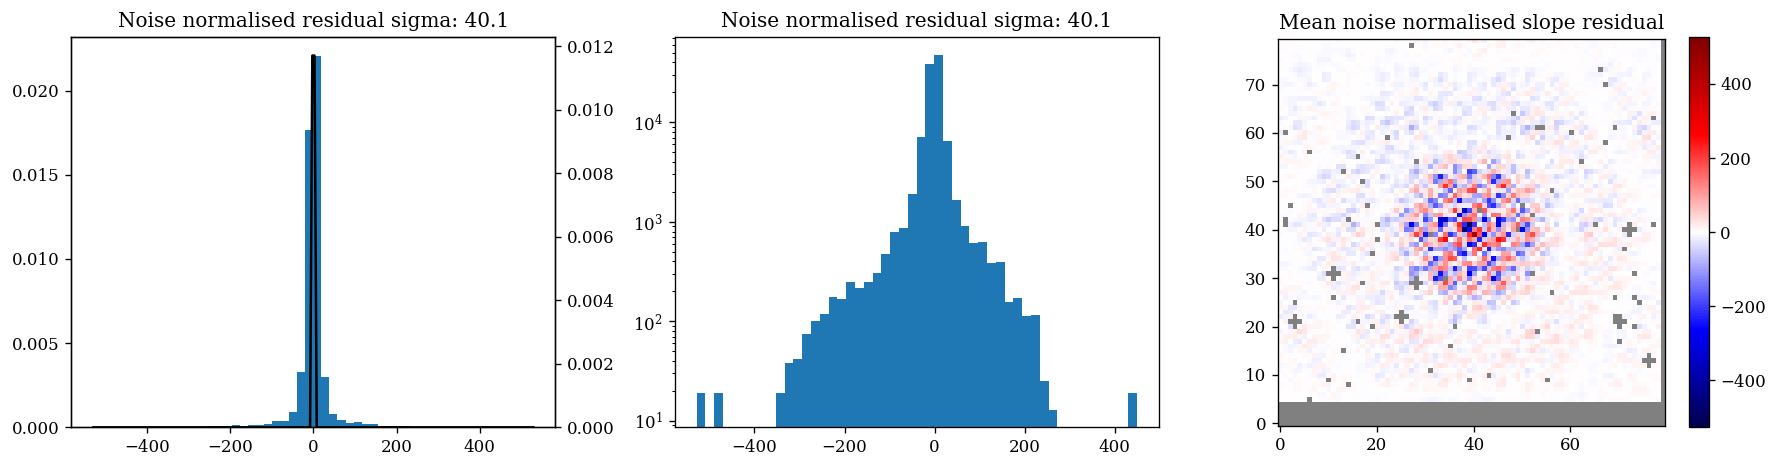

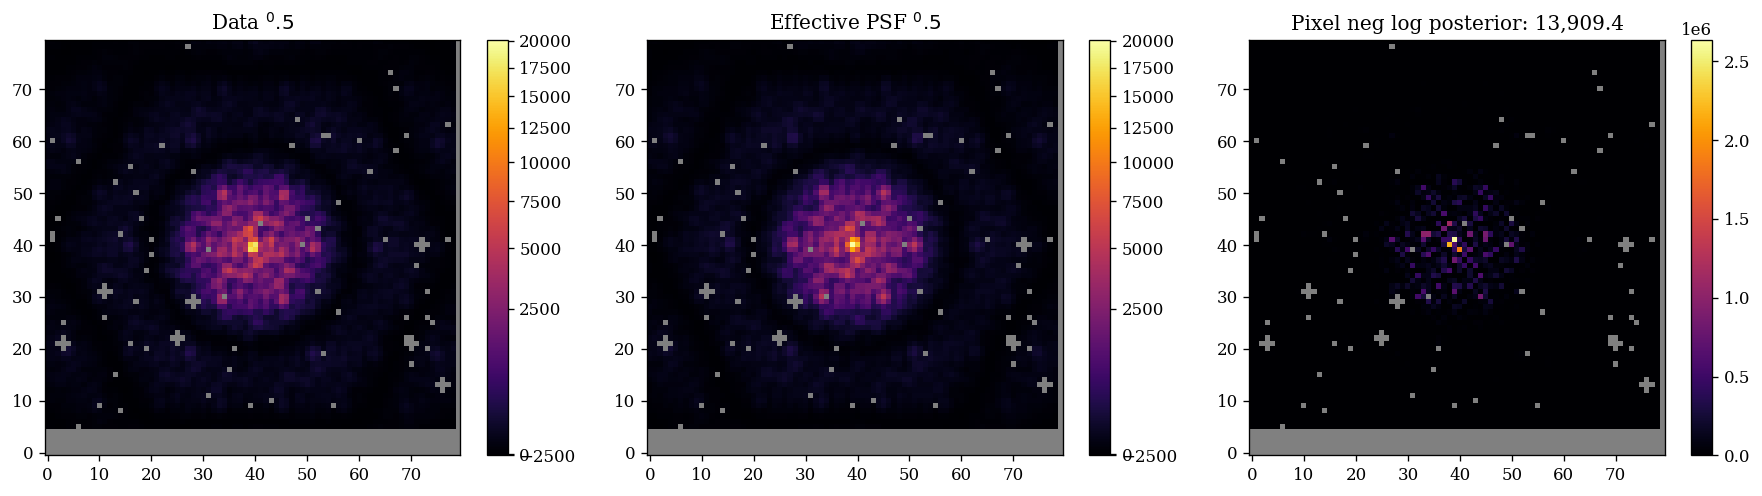

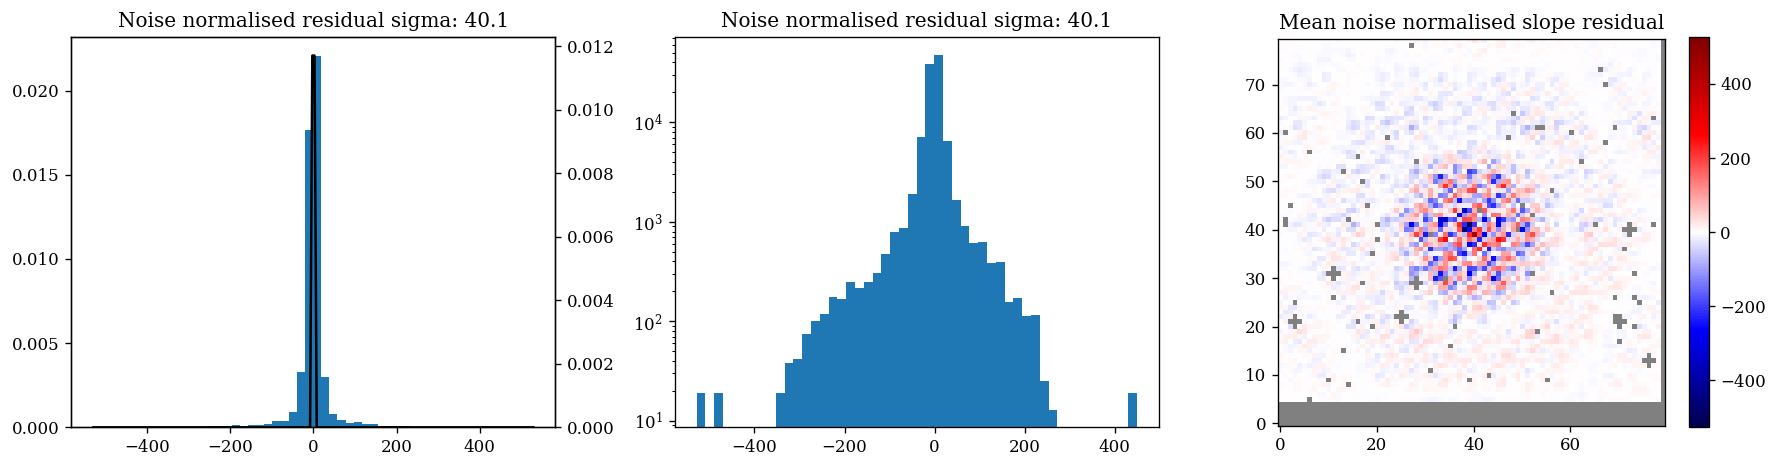

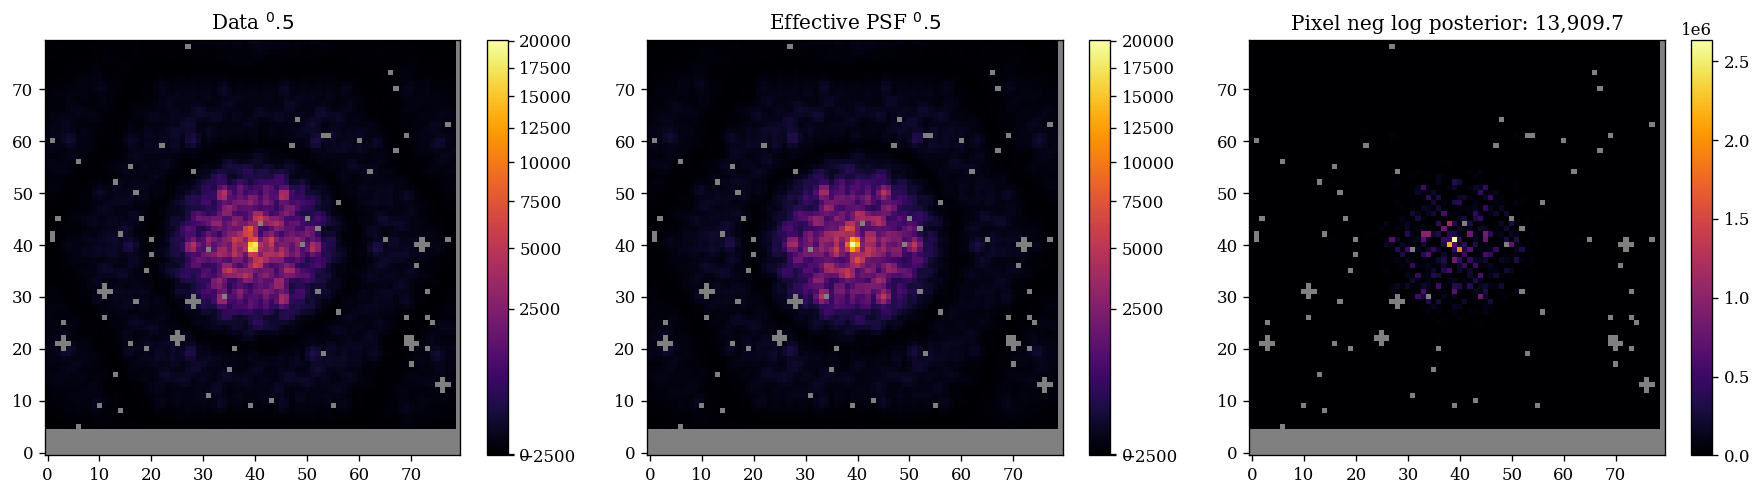

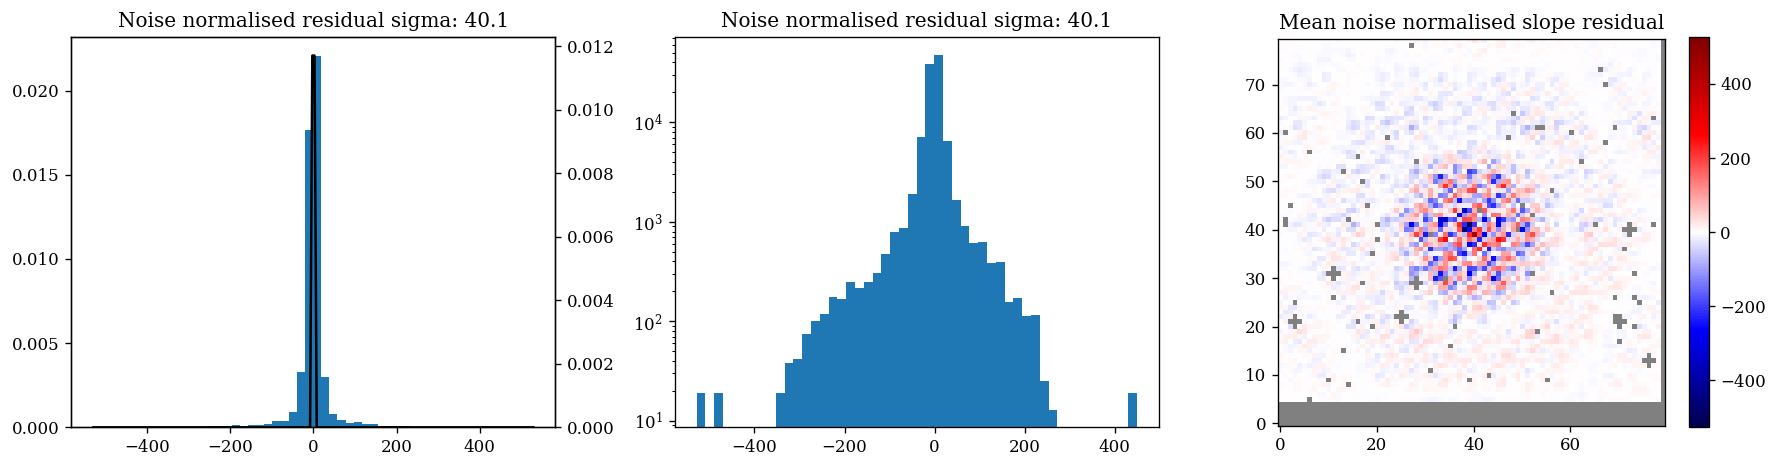

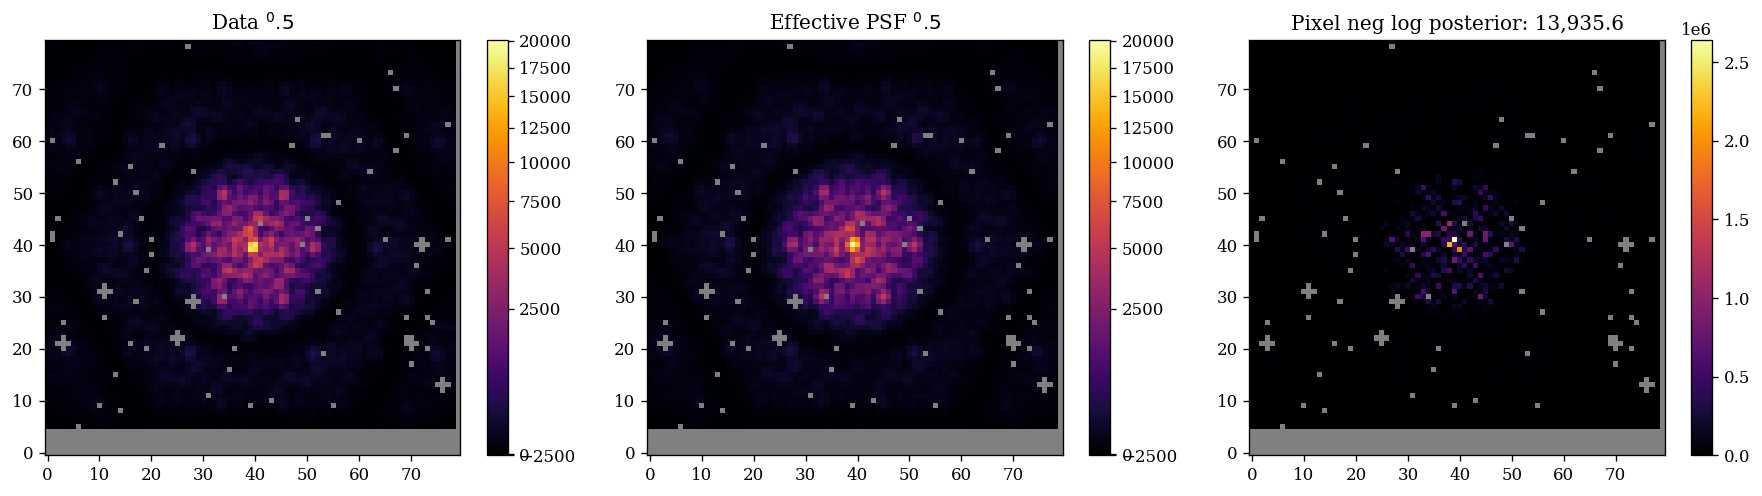

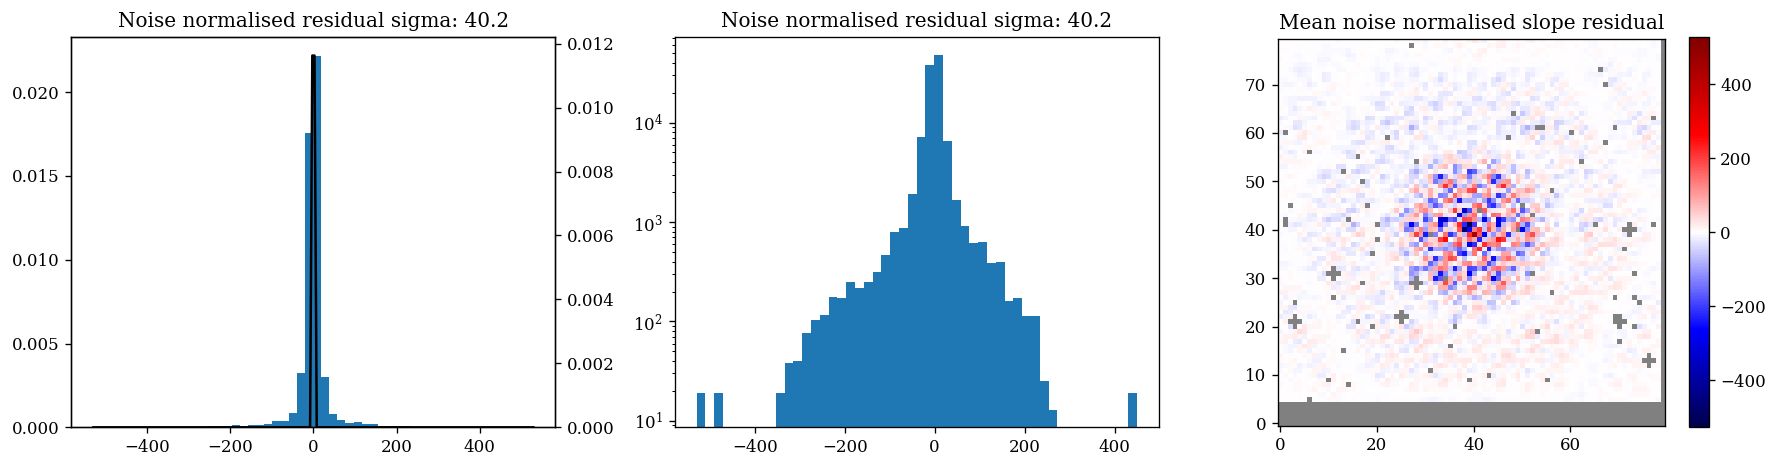

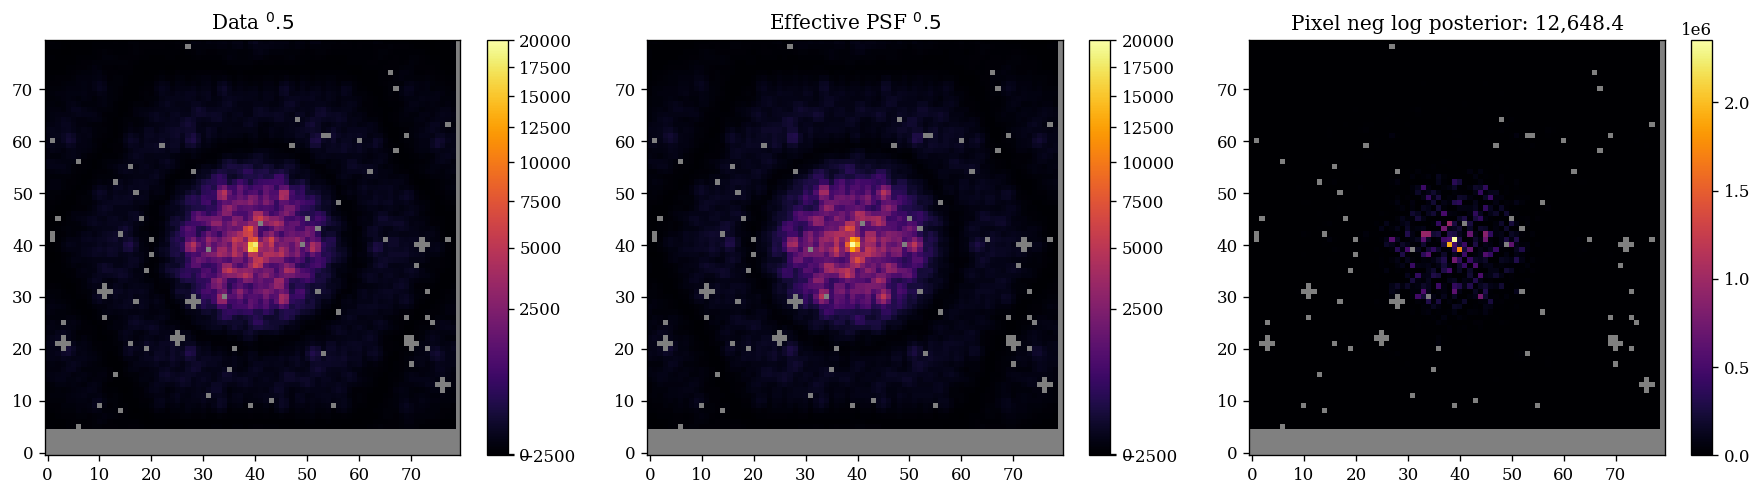

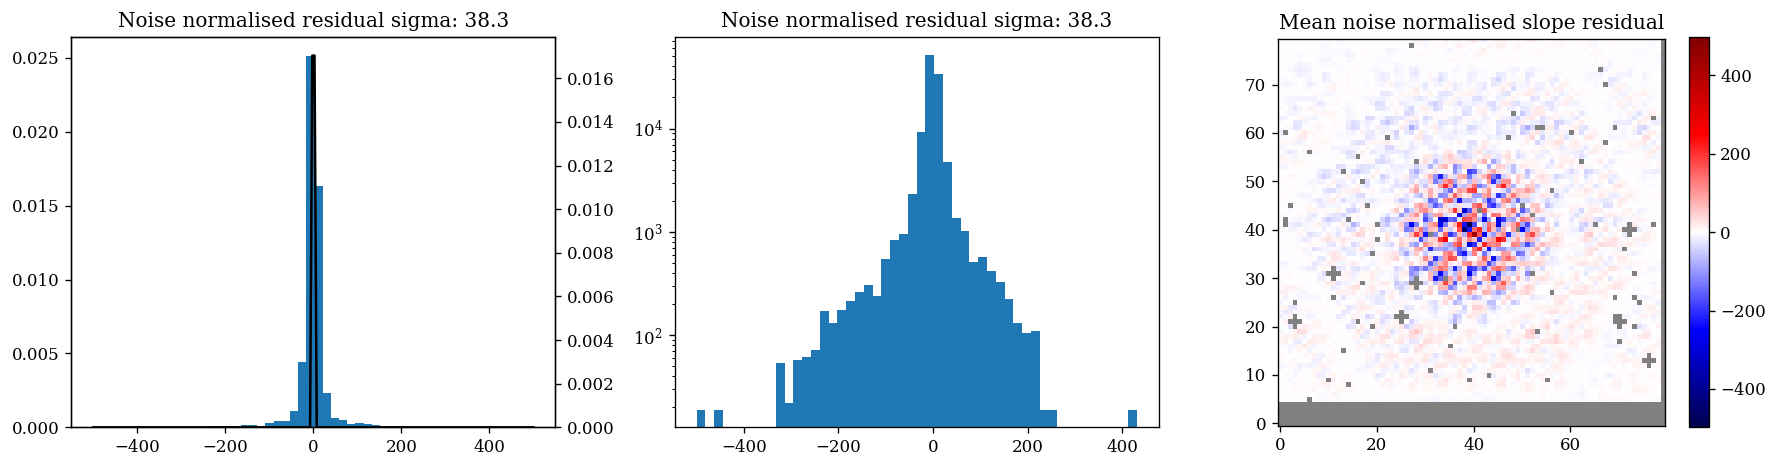

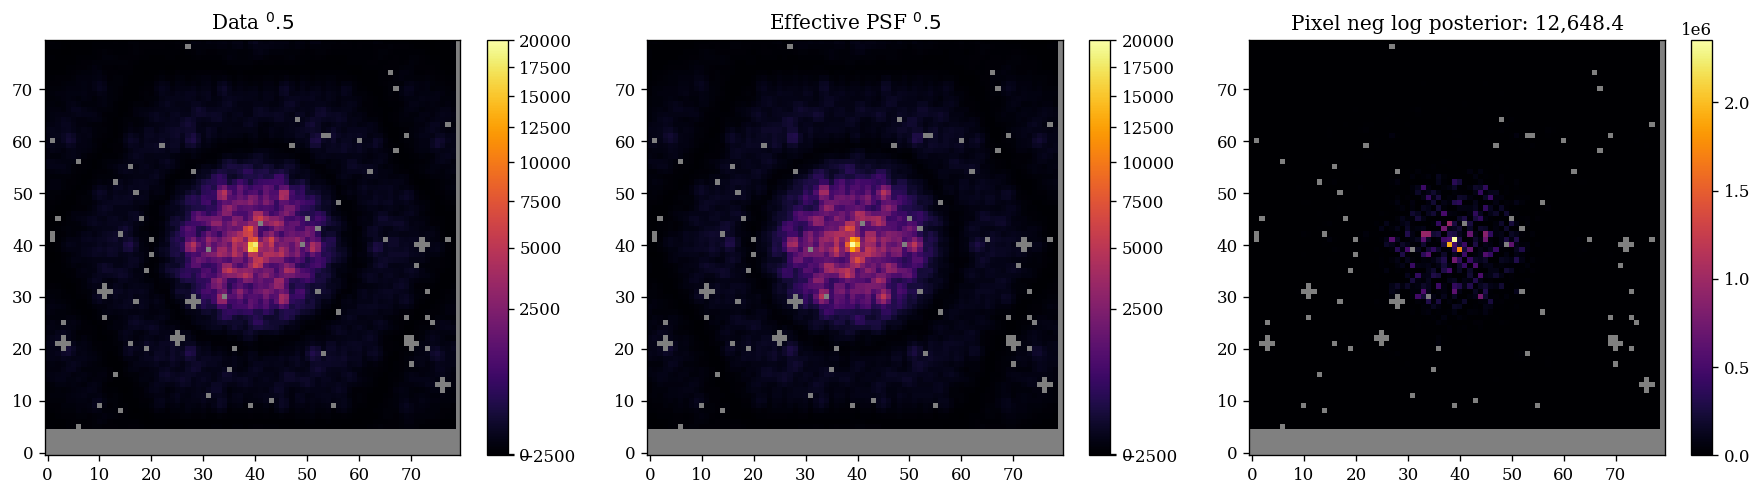

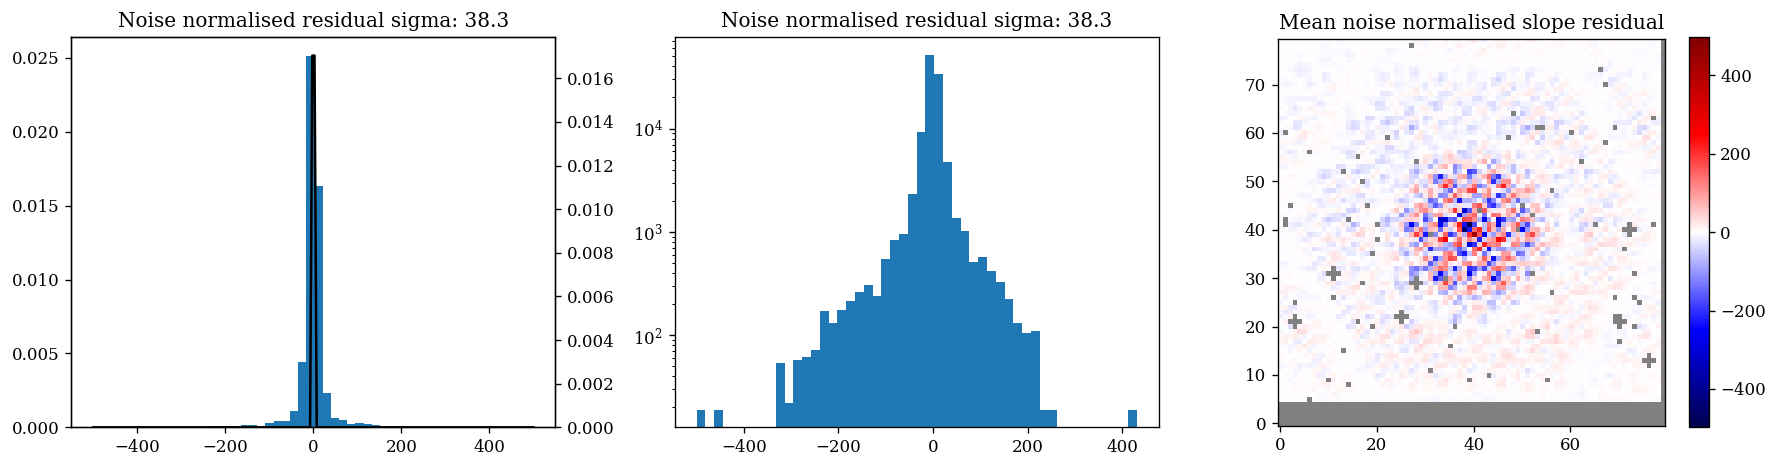

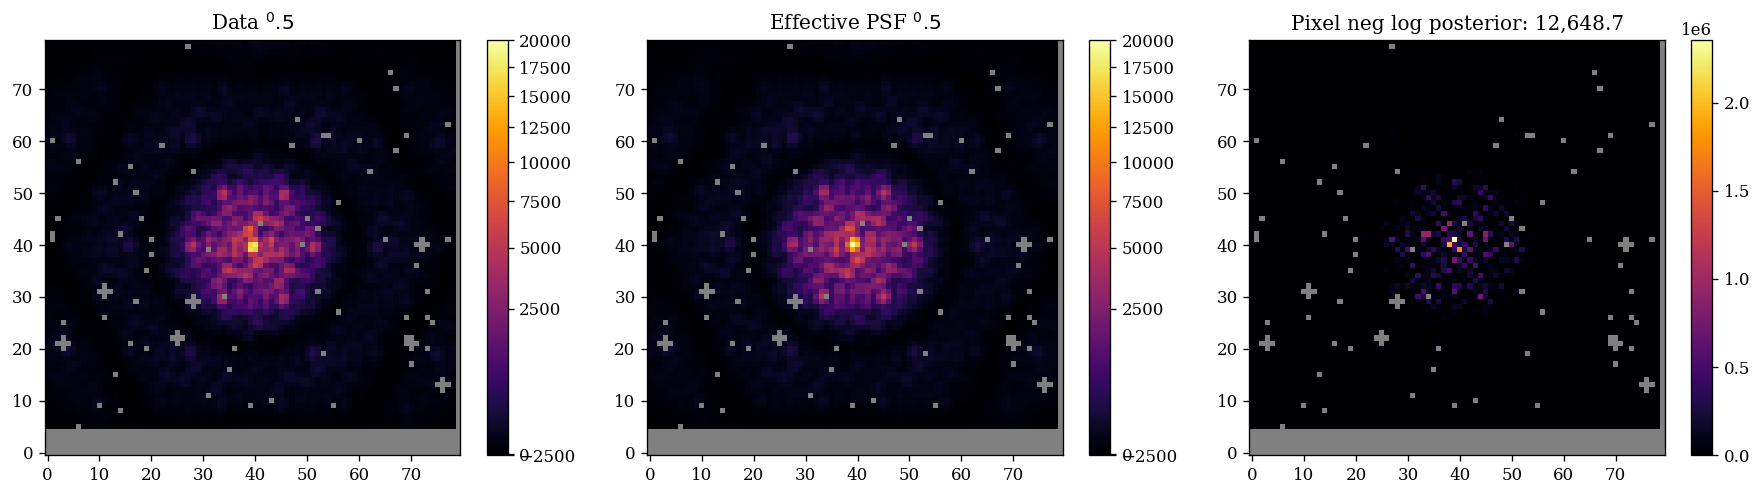

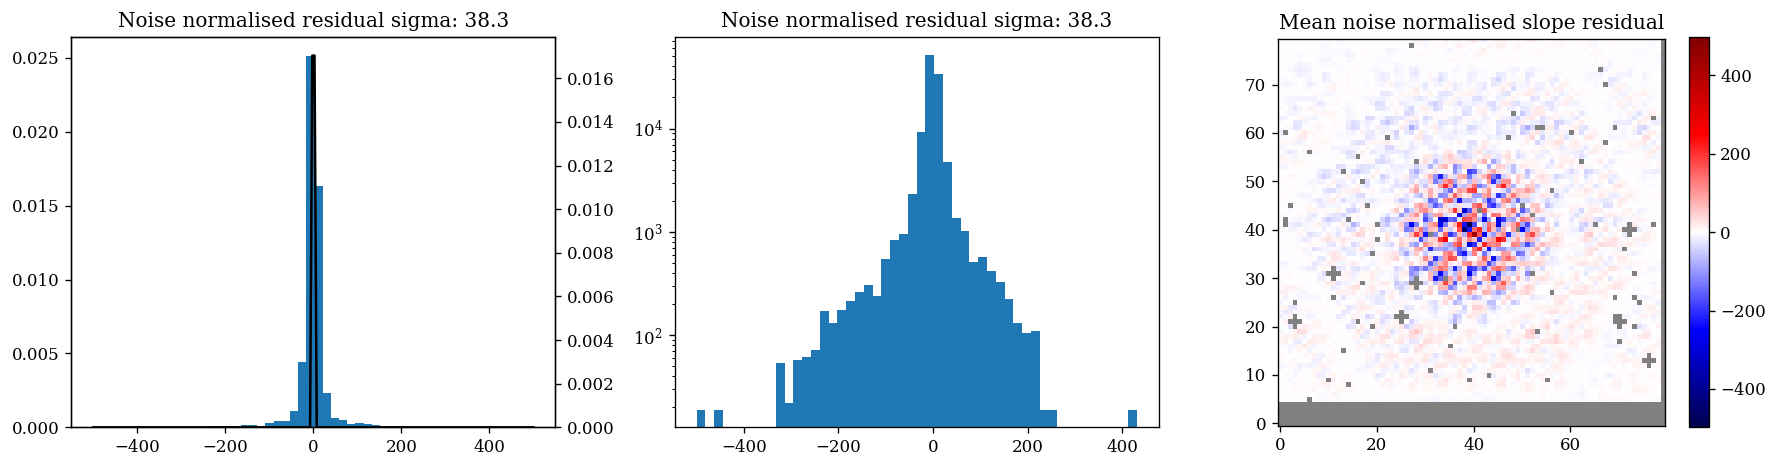

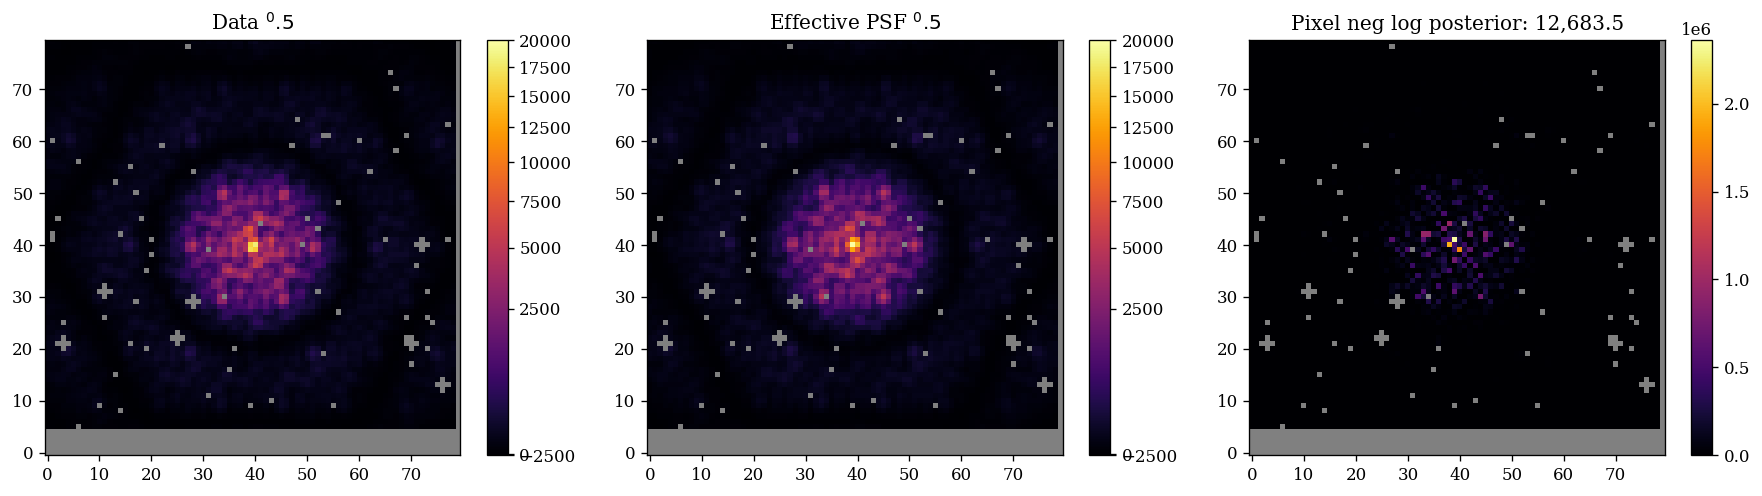

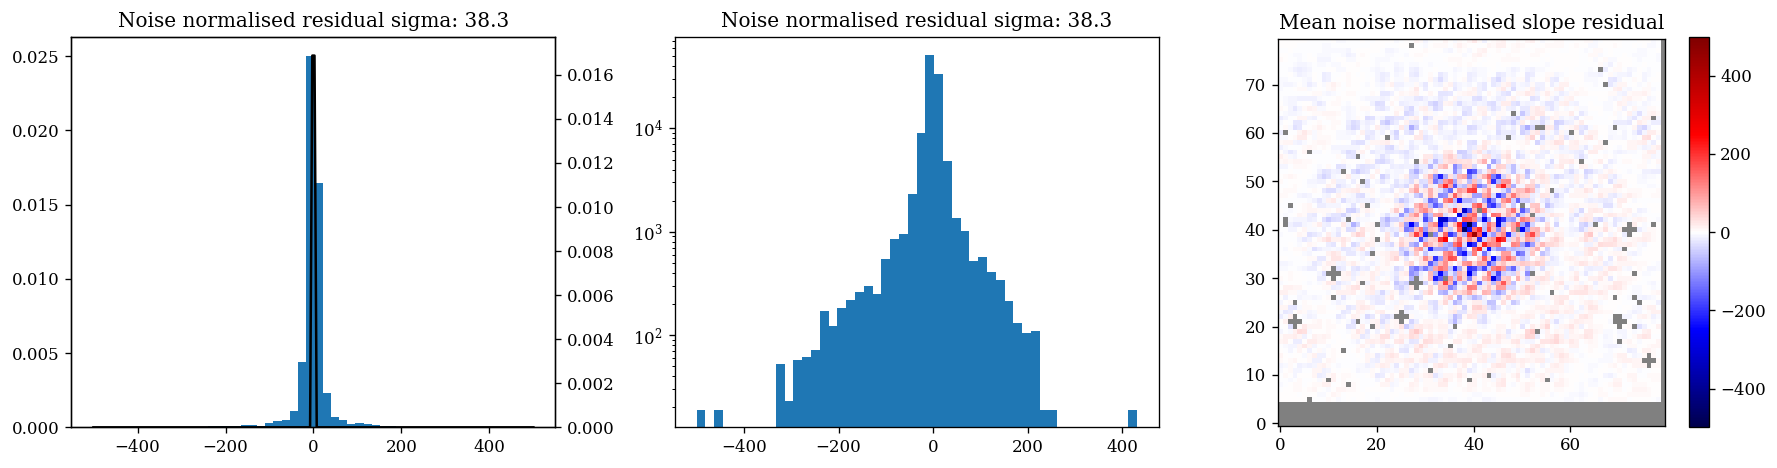

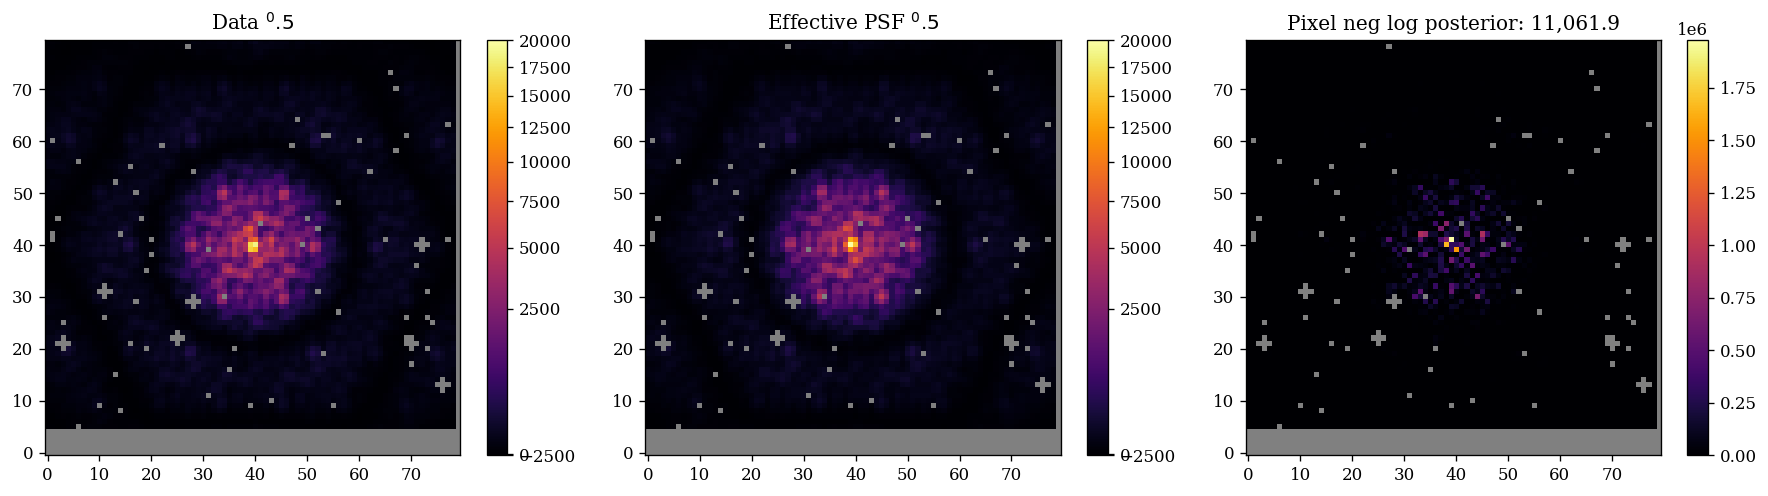

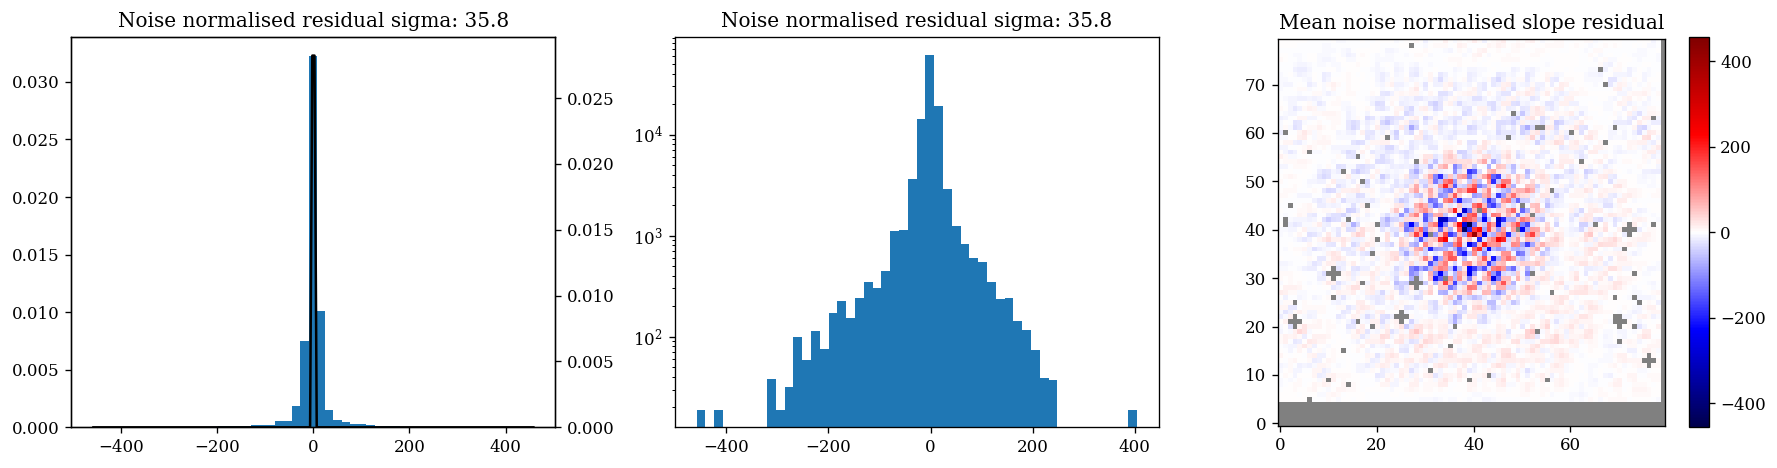

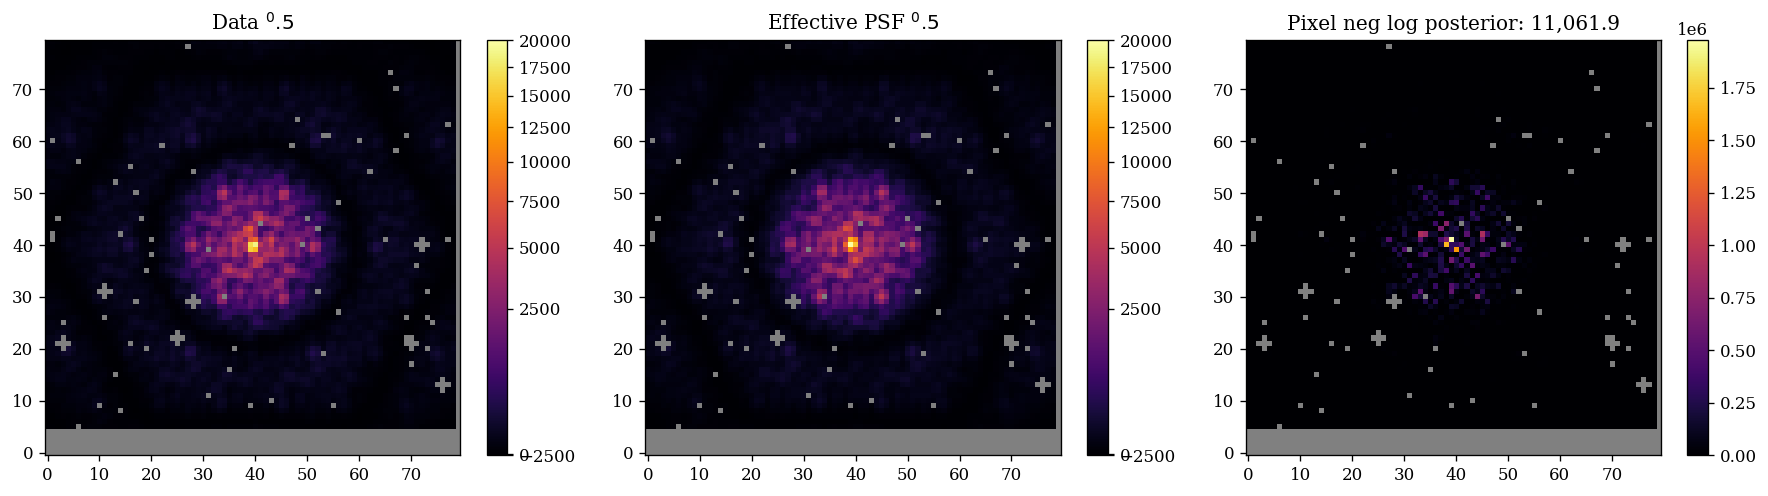

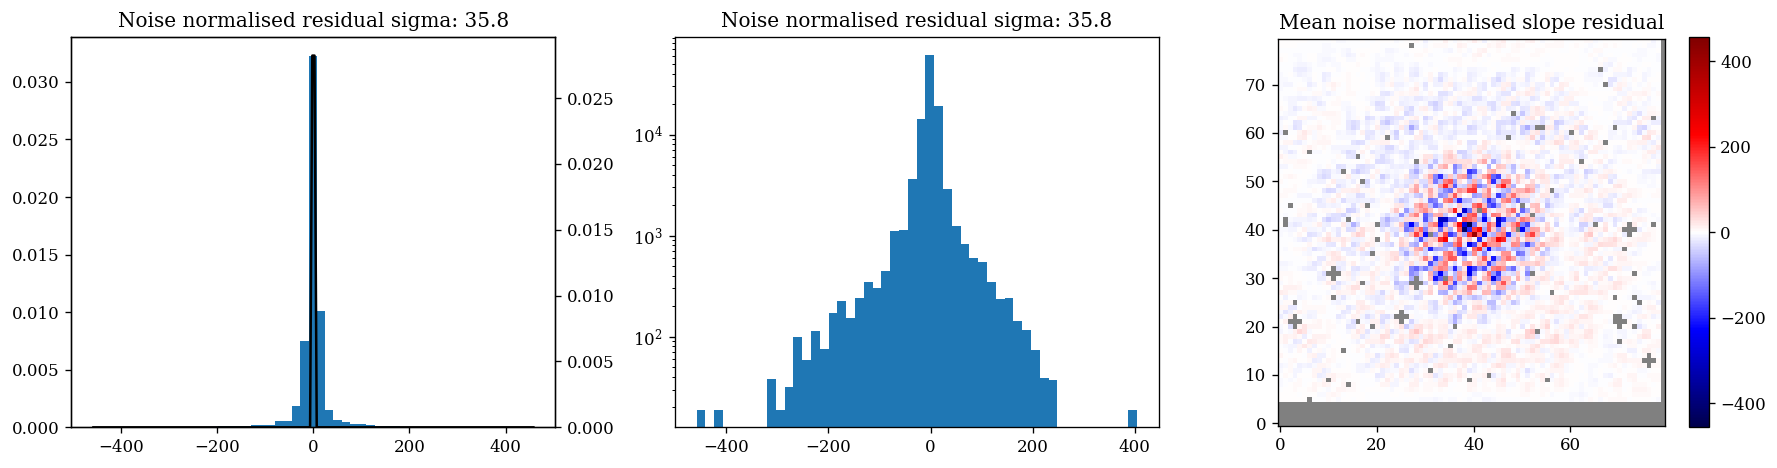

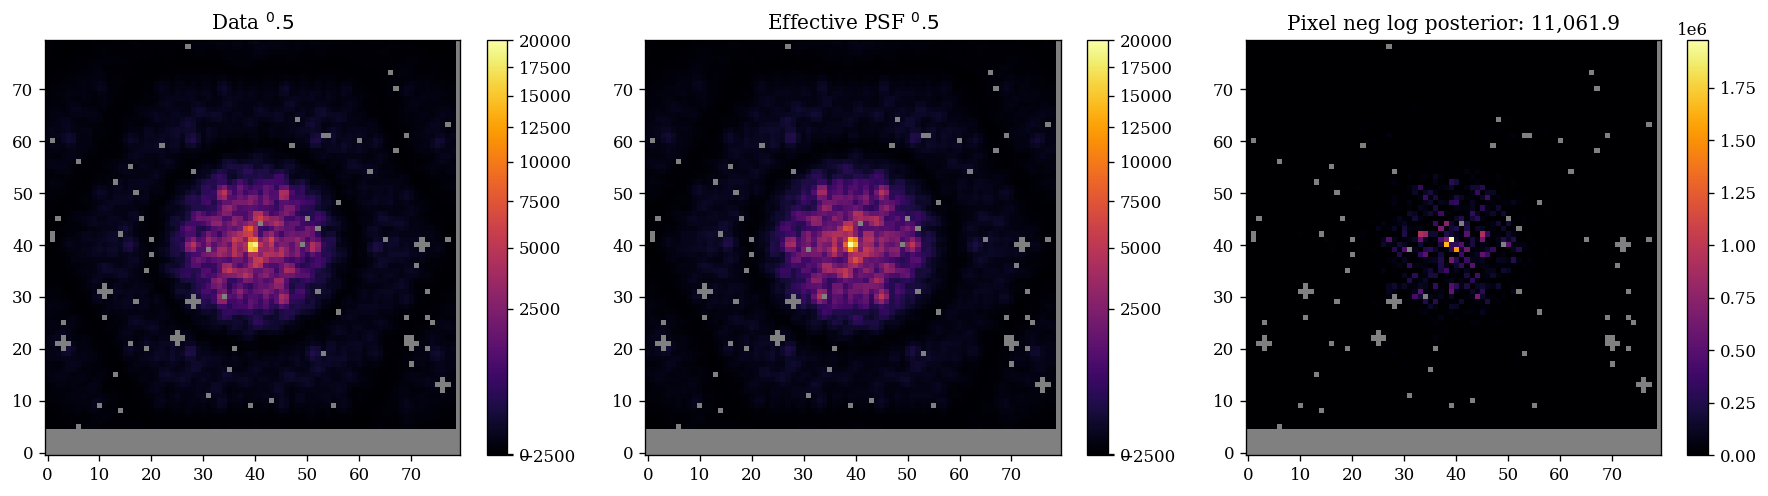

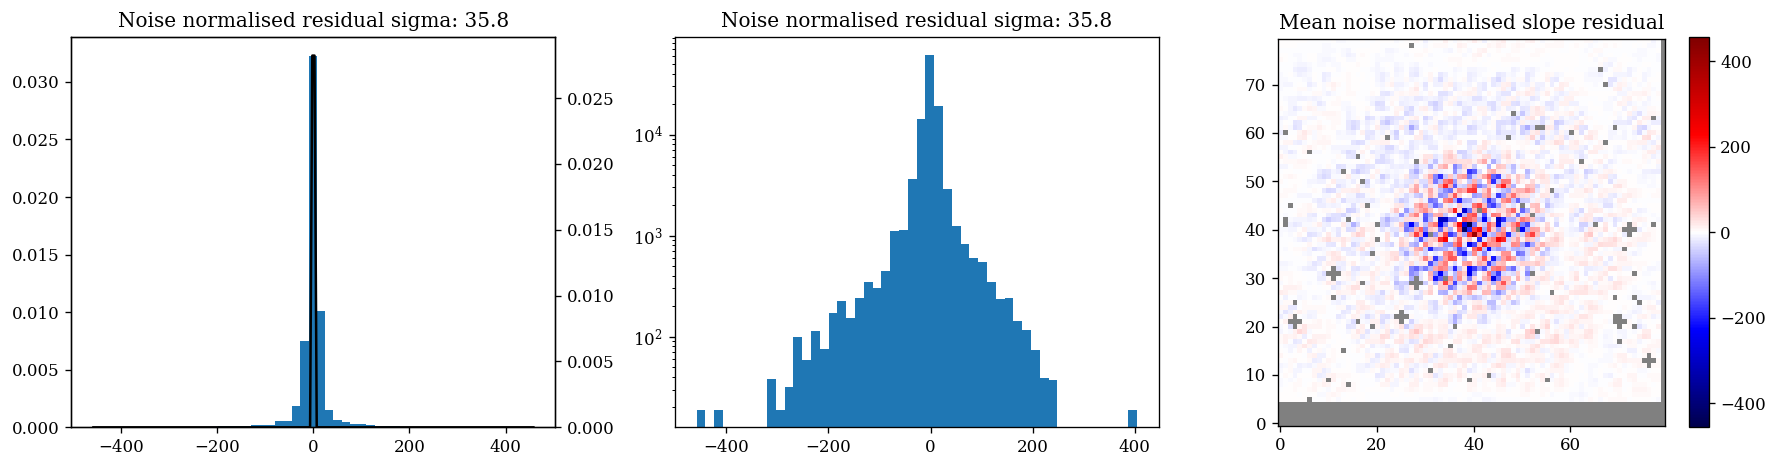

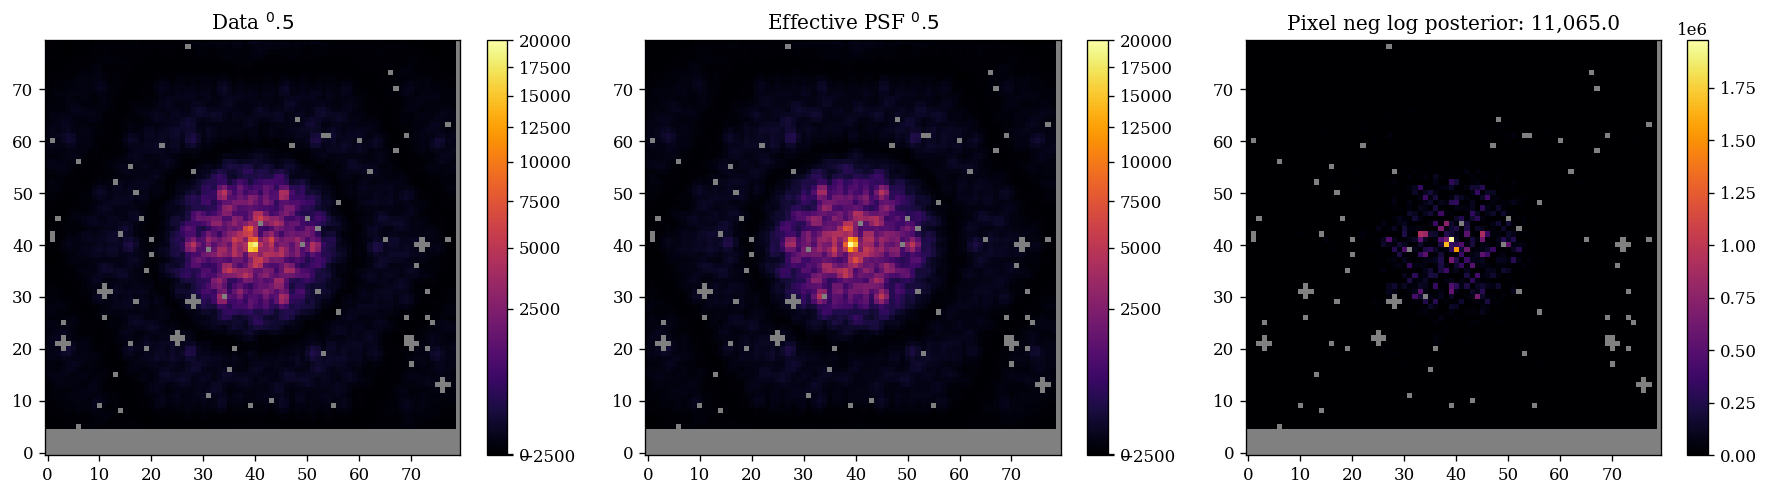

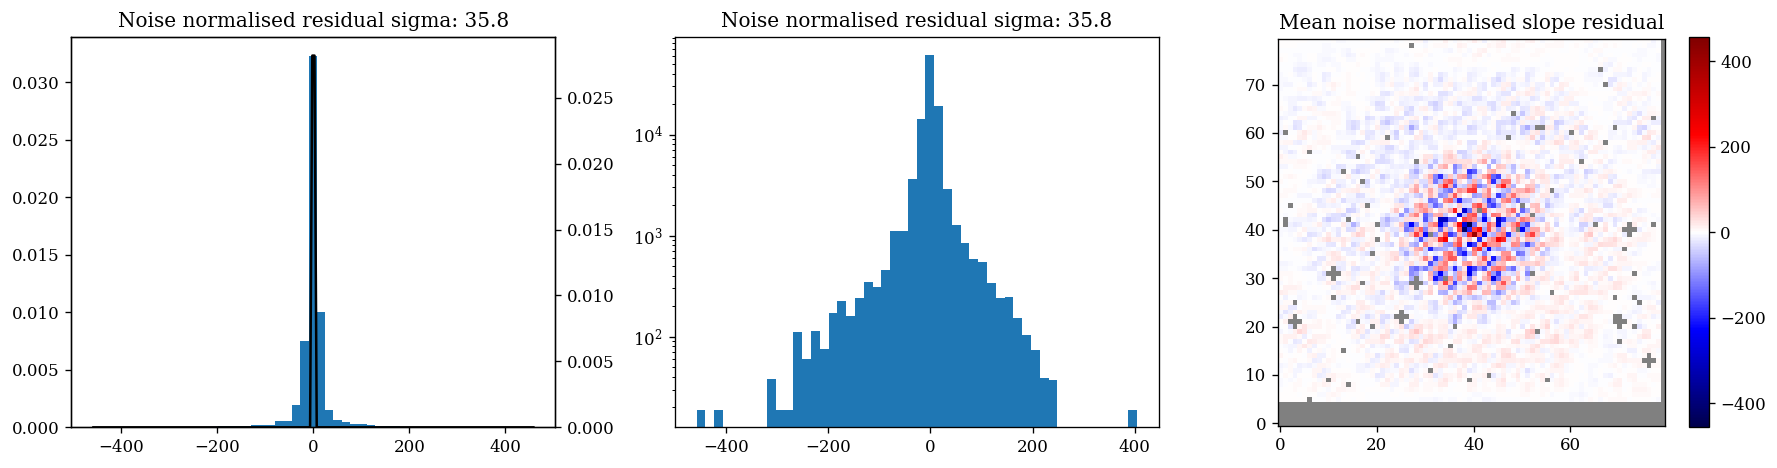

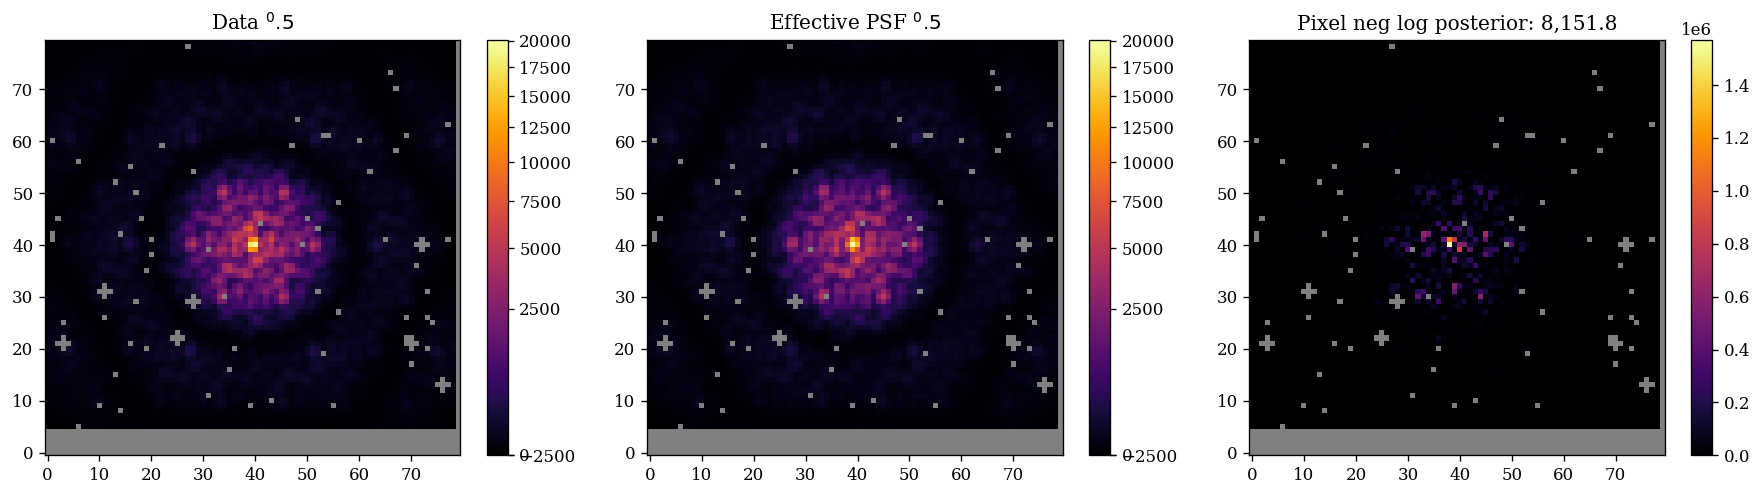

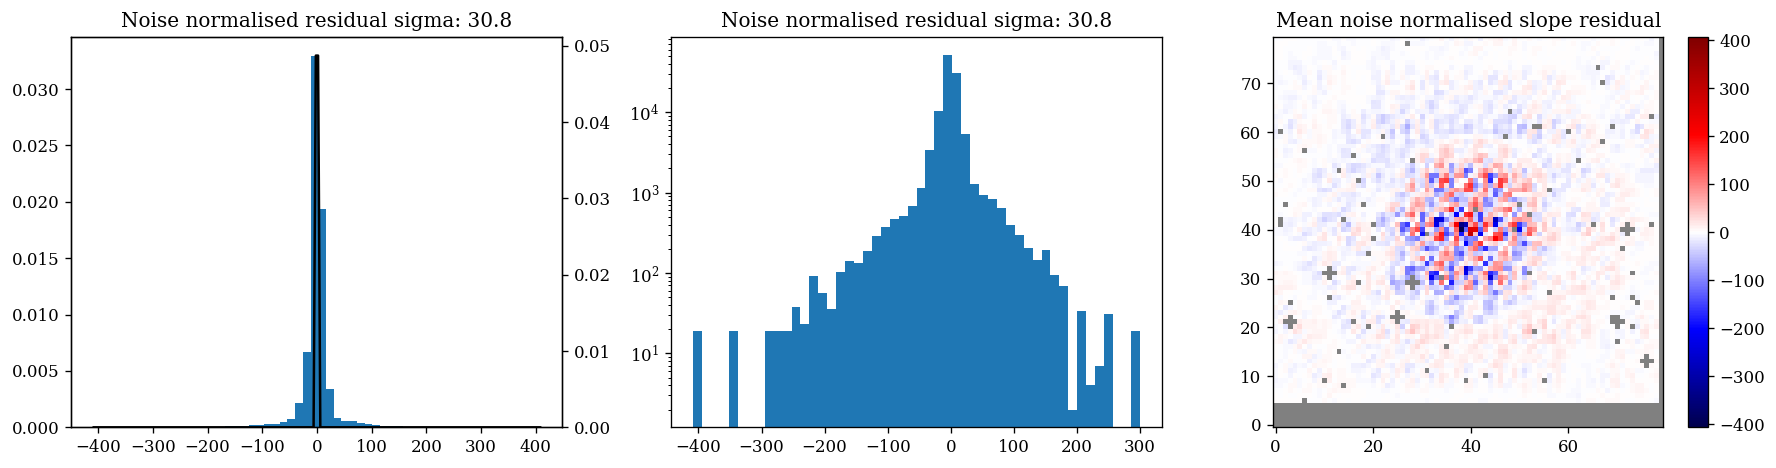

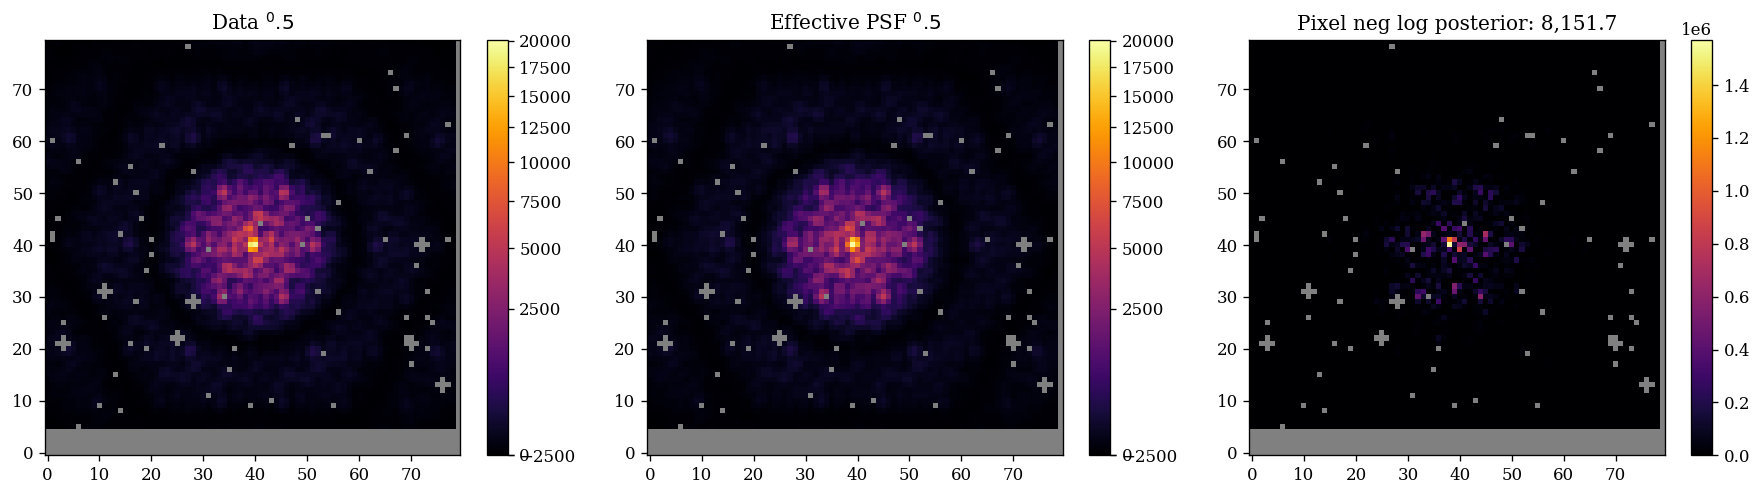

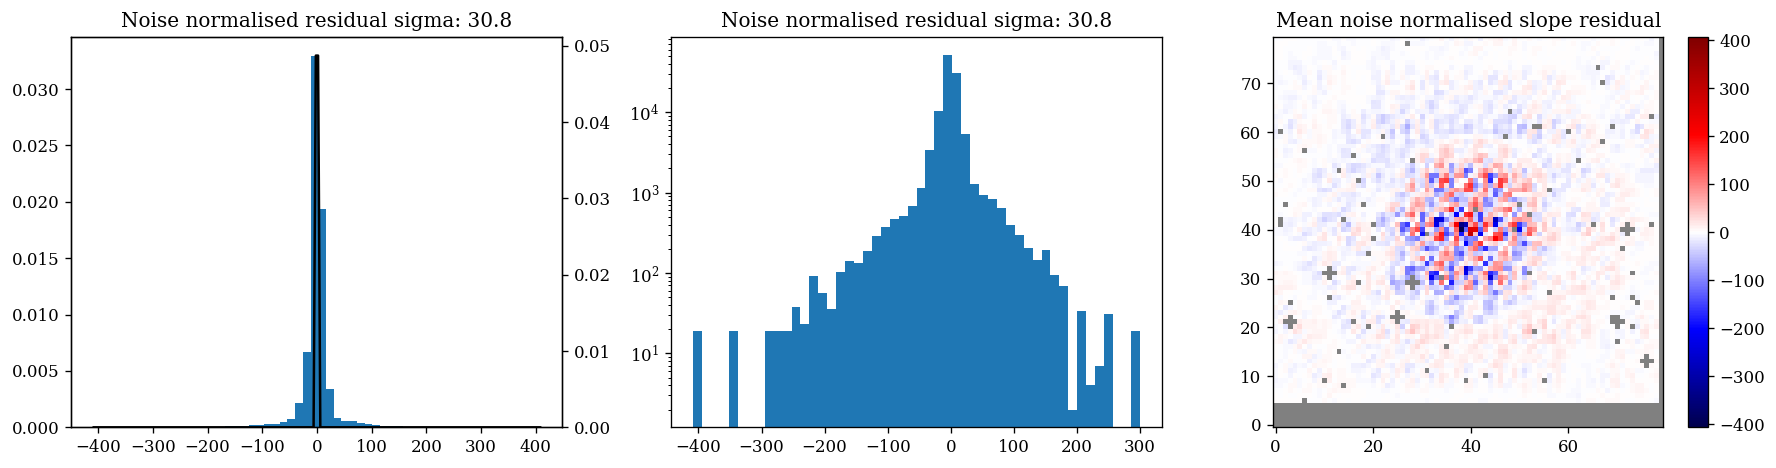

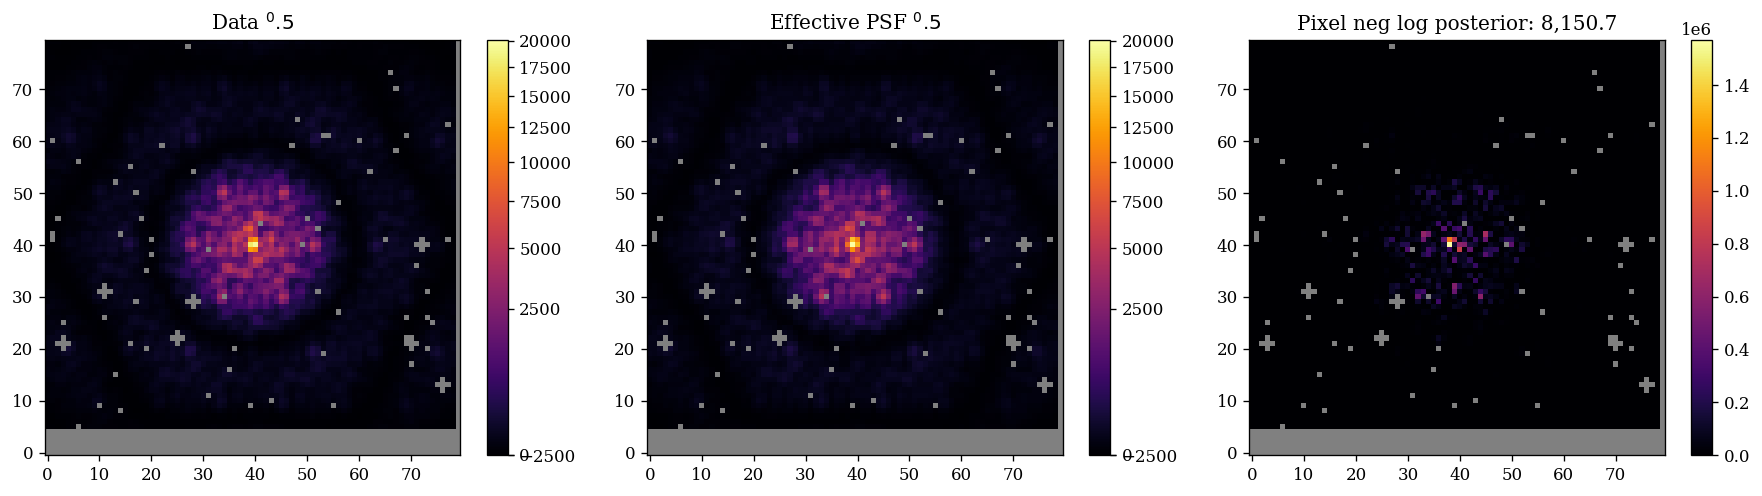

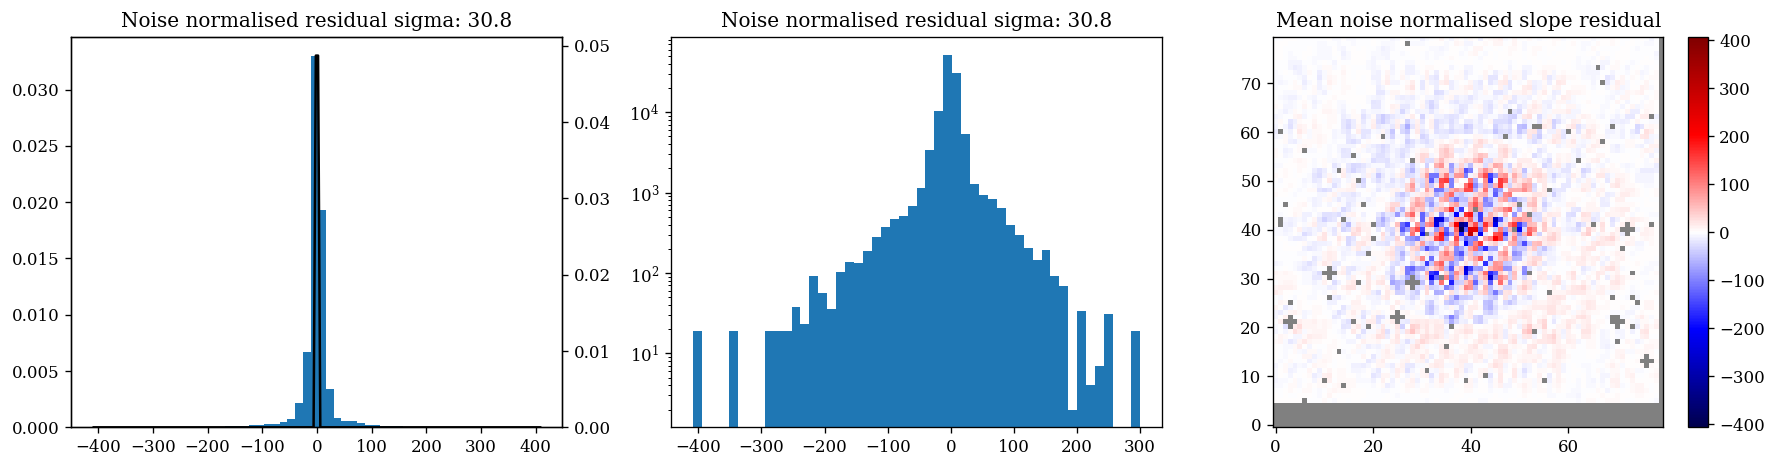

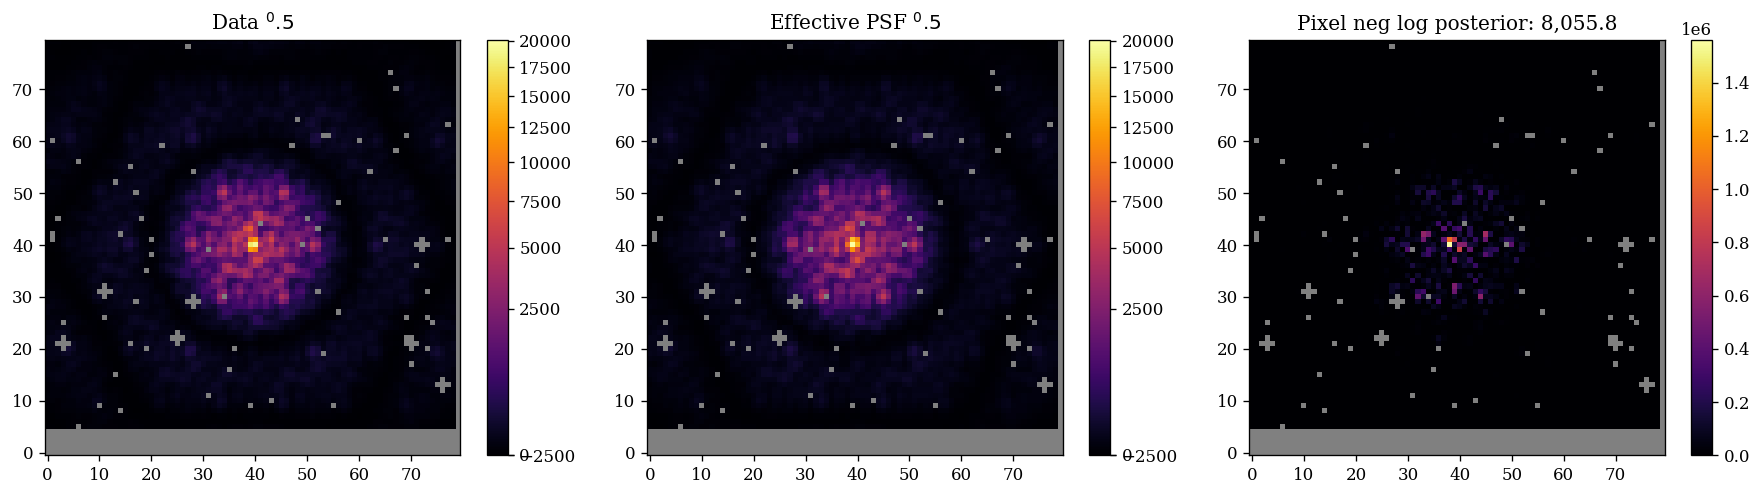

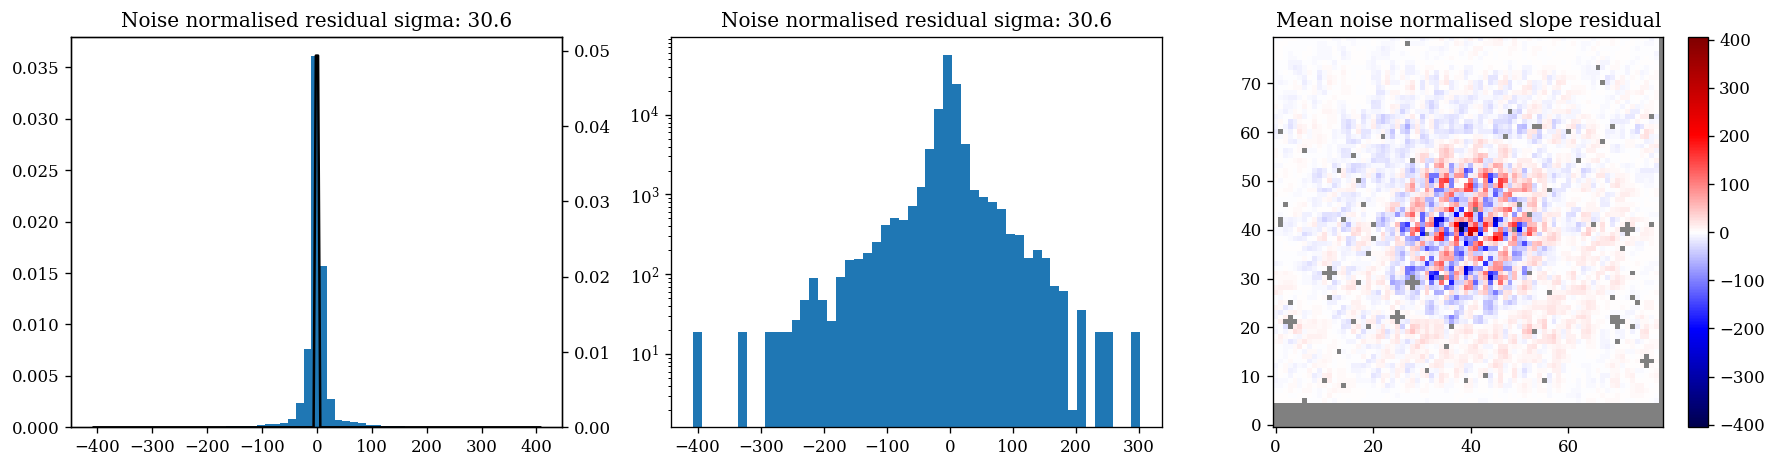

In [9]:
from amigo.plotting import summarise_fit
for exp in new_exposures:
    summarise_fit(exp, model, residuals=True, histograms=True)

In [10]:
from amigo.fisher import calc_fishers

params = [
    "positions",
    "aberrations",
    "fluxes",
    # "one_on_fs",
    # "rotation",
    # "compression",
    # "shear",
    # "translation",
    # "f2f",
    # "holes",
    # "dark_current",
    # "jitter.r",
    # "ramp.coeffs",
    # "anisotropy.compression",
    # "SRF",
    # "ipc",
    # "FF",
]
fishers = calc_fishers(model, new_exposures, params, recalculate=True, save=False)

2024-06-08 17:06:37.033153: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2734, f64[] %constant.164), window={size=1x32x32 stride=1x32x32}, to_apply=%region_1.123

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-08 17:06:37.132172: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.103933s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2734, f64[] %constant.164), window={size=1

In [11]:
def grad_fn(model, grads, args, key):
    # grads = jax.tree_map(lambda x: np.where(np.isnan(x), 0.0, x), grads)
    if grads.holes is not None:
        grads = grads.set("holes", grads.holes * np.ones((7, 2)).at[:3, :].set(0))
    return grads, key

In [12]:
from amigo.fitting import optimise
import jax.random as jr
import optax

def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

batch_size = 1
nbatch = len(exposures) // batch_size
if len(exposures) % batch_size != 0:
    nbatch += 1
optimisers = {
    "positions": sgd(2e-1, 0),
    "aberrations": sgd(1e-2, 5),
    "fluxes": sgd(2e-1, 10),
    # "one_on_fs": sgd(0, 10),
    # "shear": sgd(2e-1, 15),
    # "rotation": sgd(2e-1, 15),
    # "compression": sgd(2e-1, 15),
    # "translation": sgd(5e-2, 15),
    # "f2f": sgd(2e-1, 15),
    # "dark_current": sgd(2e-1, 20),
    # "jitter.r": sgd(5e-1, 20),
    # "holes": sgd(2e-1, 25),
    # "ramp.coeffs": adam(5e-6, 30 * nbatch),
}


# model = model.set("ramp", polyEDM)


# Optimisation
final_model, losses, histories, states = optimise(
    model,
    new_exposures,
    optimisers,
    epochs=25,
    key=jr.PRNGKey(0),
    fishers=fishers,
    grad_fn=grad_fn,
    print_grads=False,
    batch_size=batch_size,
    # batch_params=["ramp.coeffs"],
)

  0%|          | 0/25 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:01:29
Initial Loss: 12,563.75
Est time per epoch:  0:00:20
Est run remaining:  0:09:38
Full Time: 0:09:45
Final Loss: 87.14


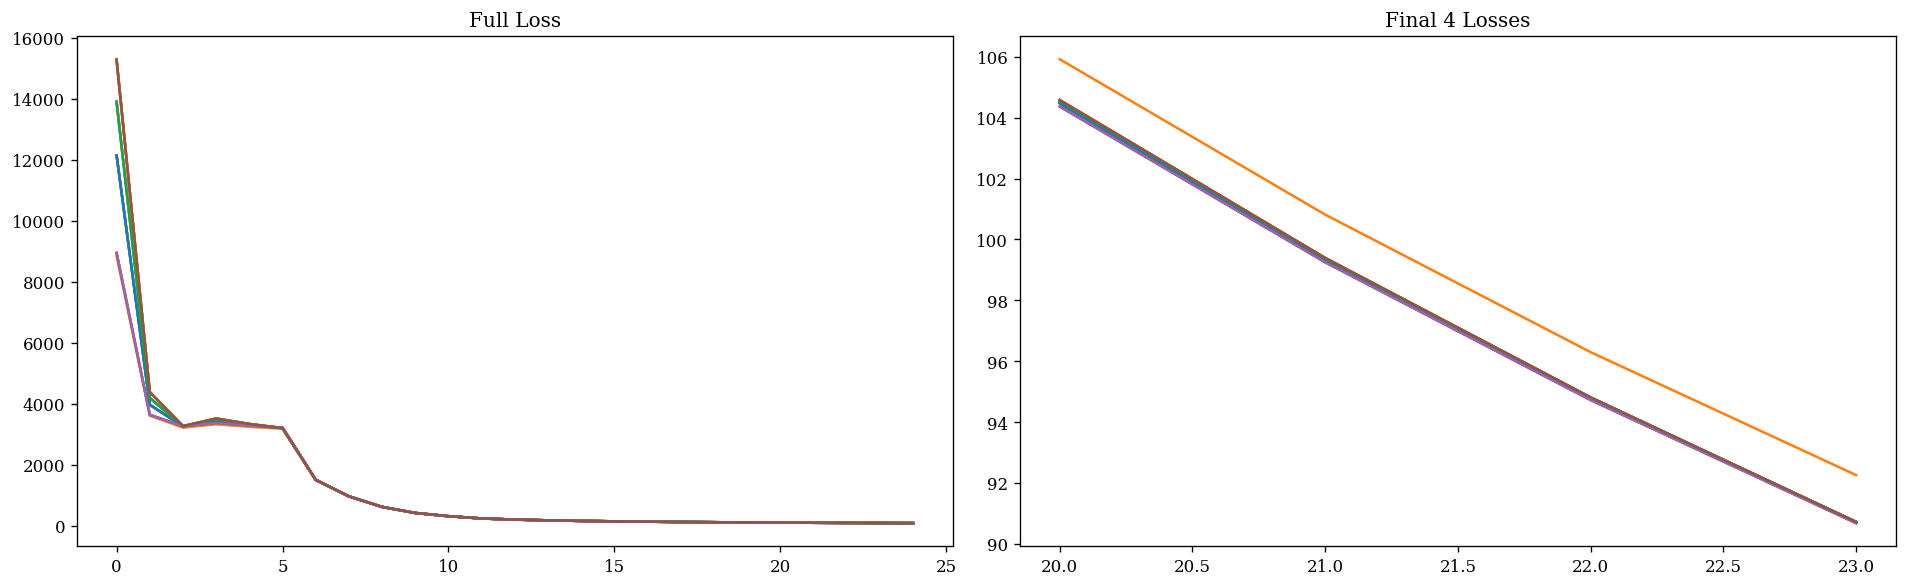

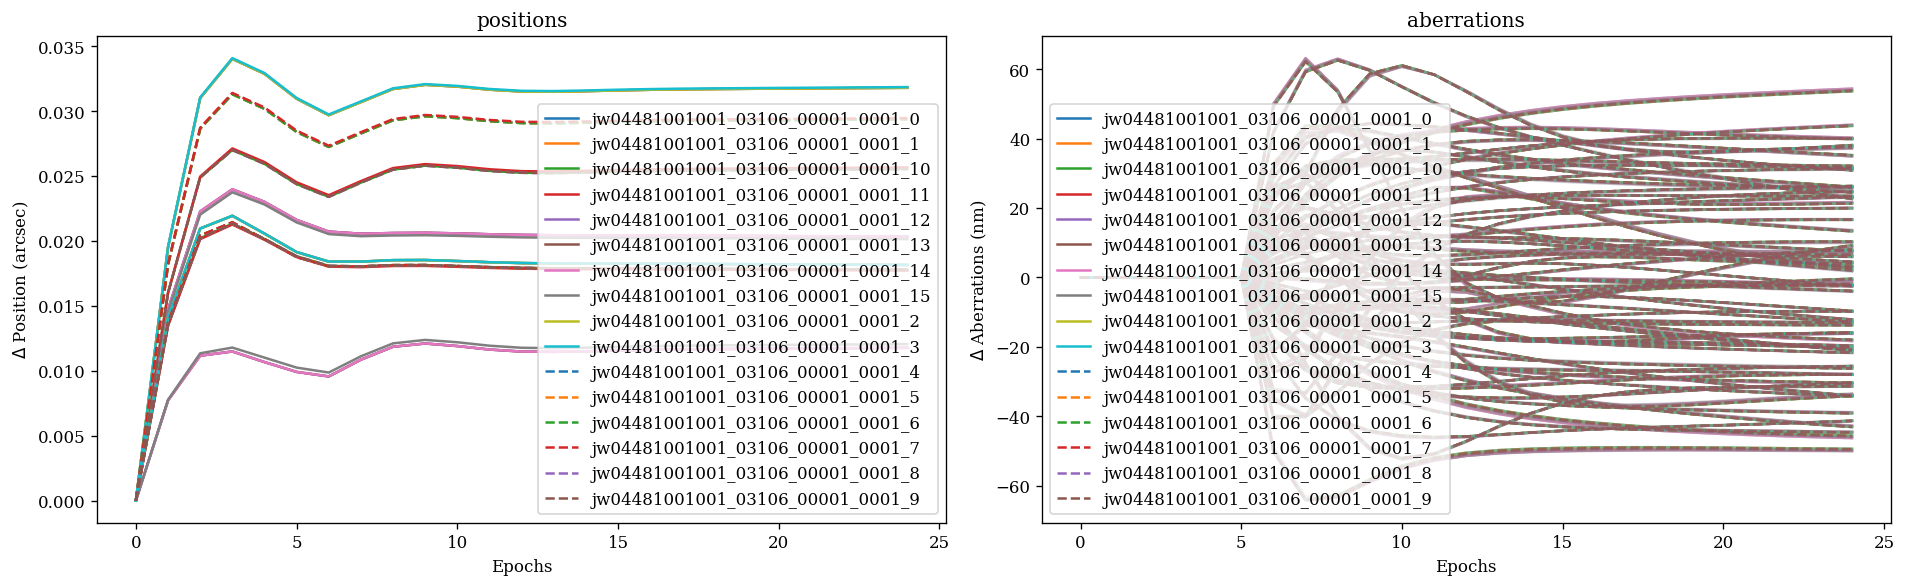

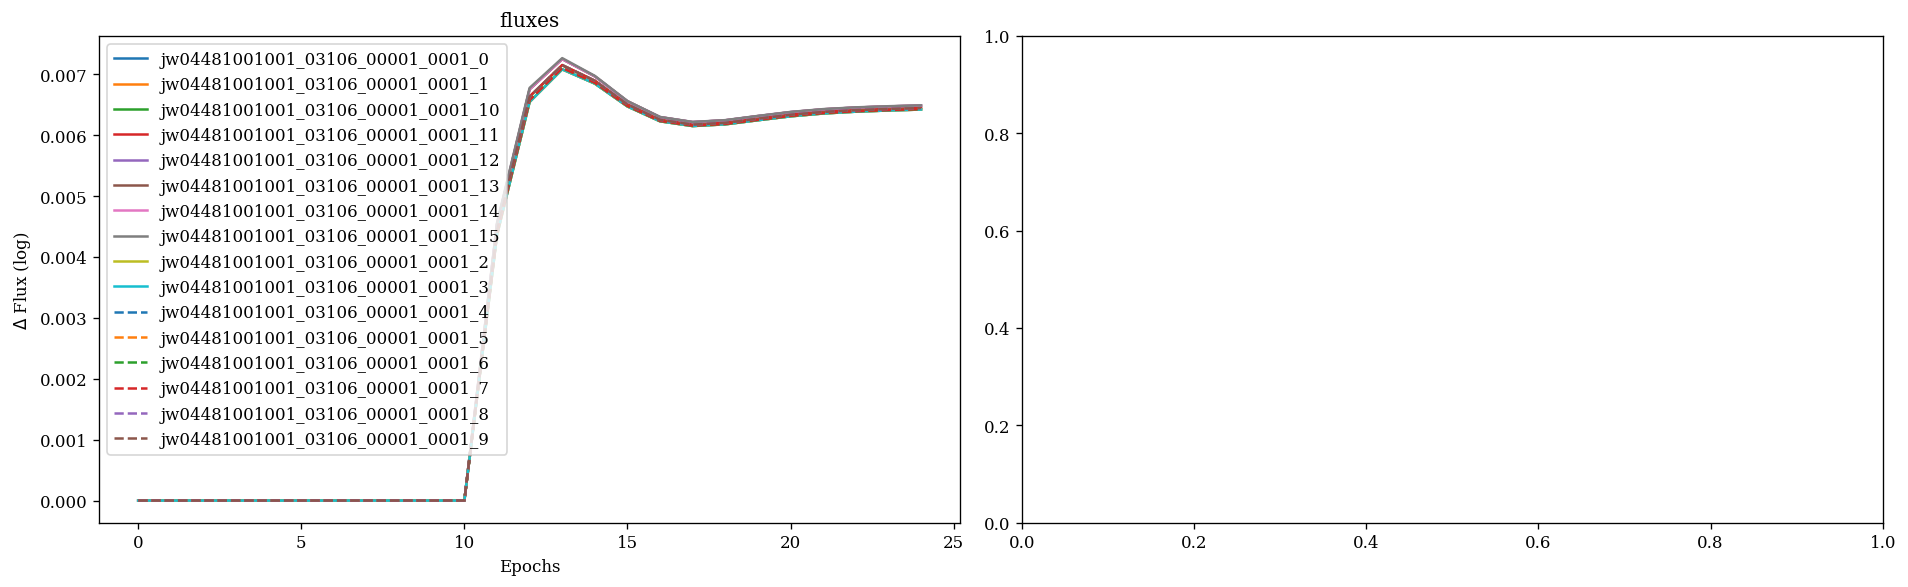

In [13]:
from amigo.plotting import plot, plot_losses


key_fn = lambda exp: f"{exp.ngroups:<3} {exp.nints} {np.nanmean(exp.data[-1]):<5.0f}"

plot_losses(losses, start=20)

for history in histories:
    plot(history)

File jw04481001001_03106_00001_0001_0
Star HD-41094
Filter F430M
nints 905
ngroups 20



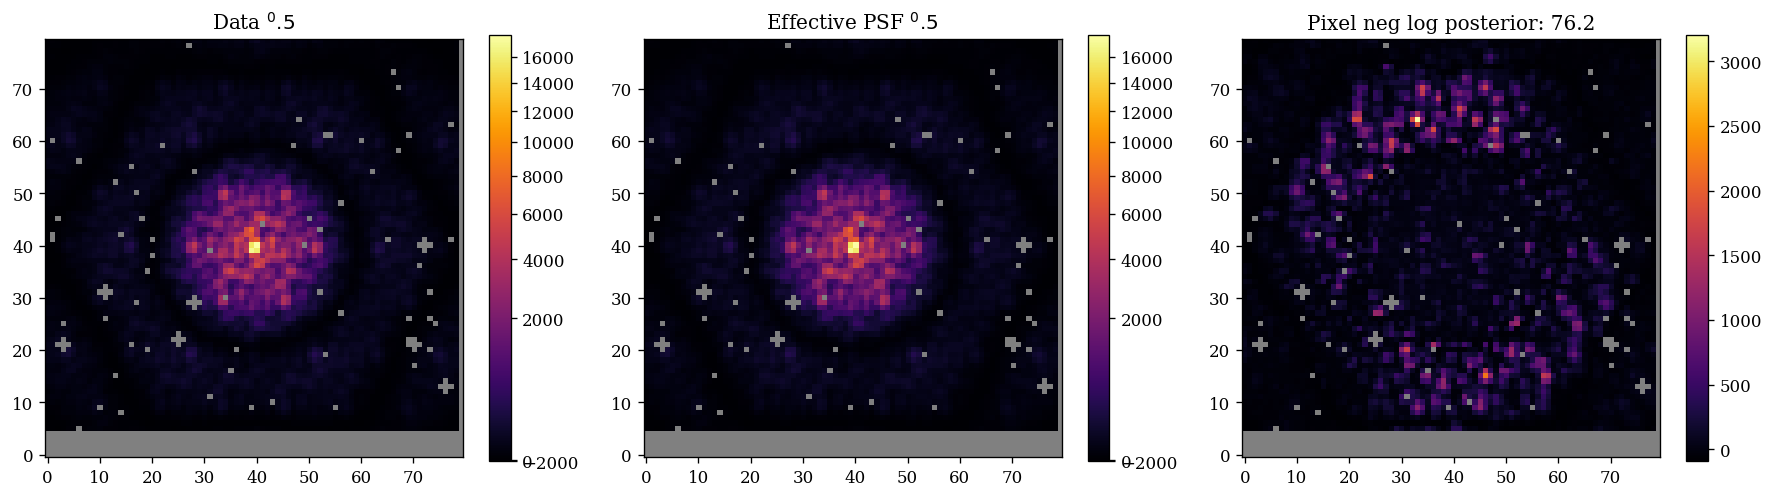

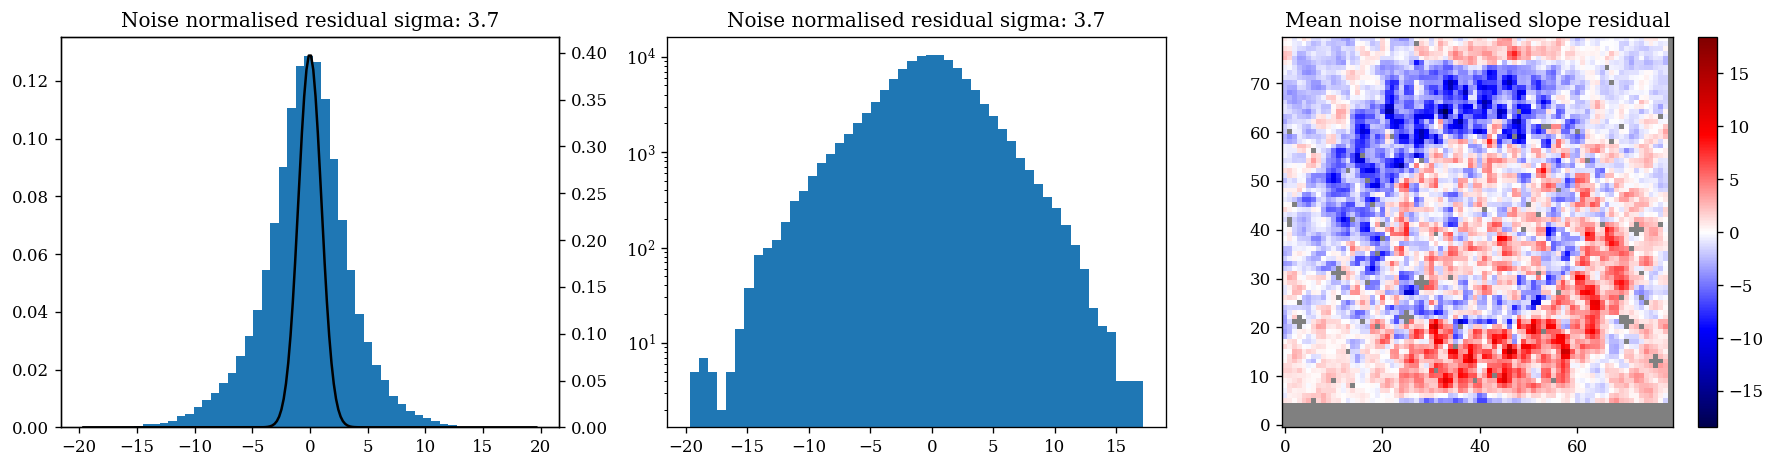

File jw04481001001_03106_00001_0001_1
Star HD-41094
Filter F430M
nints 905
ngroups 20



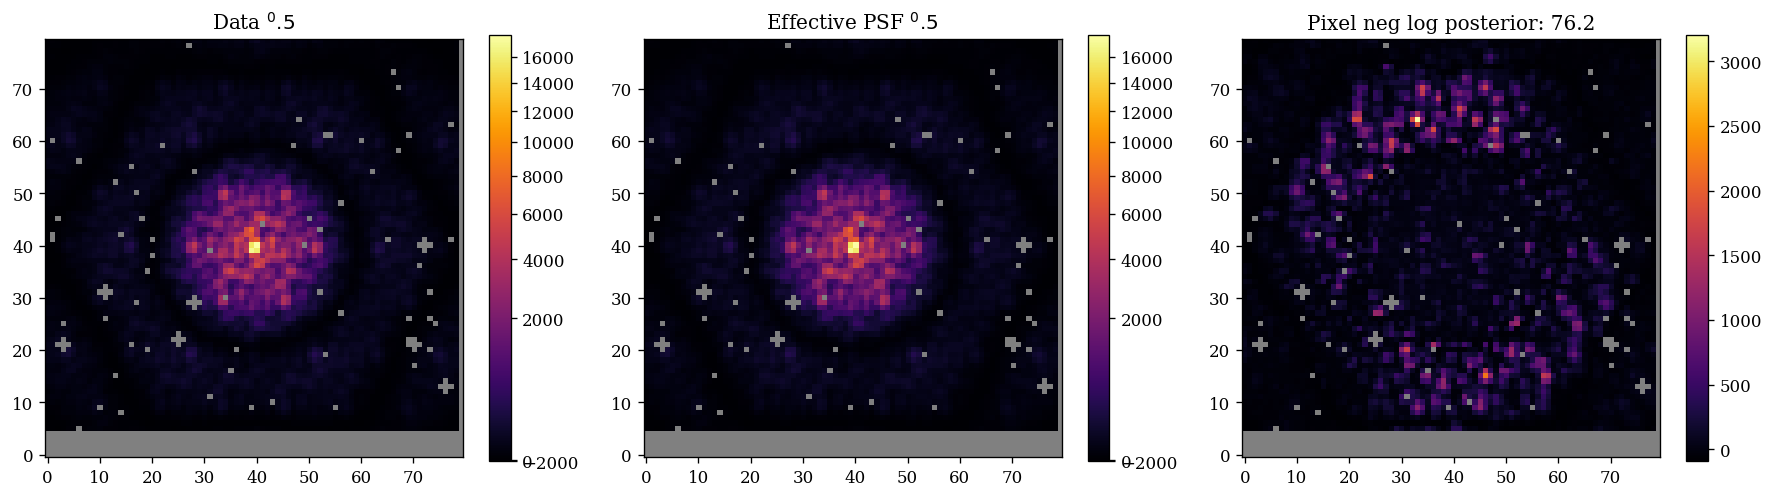

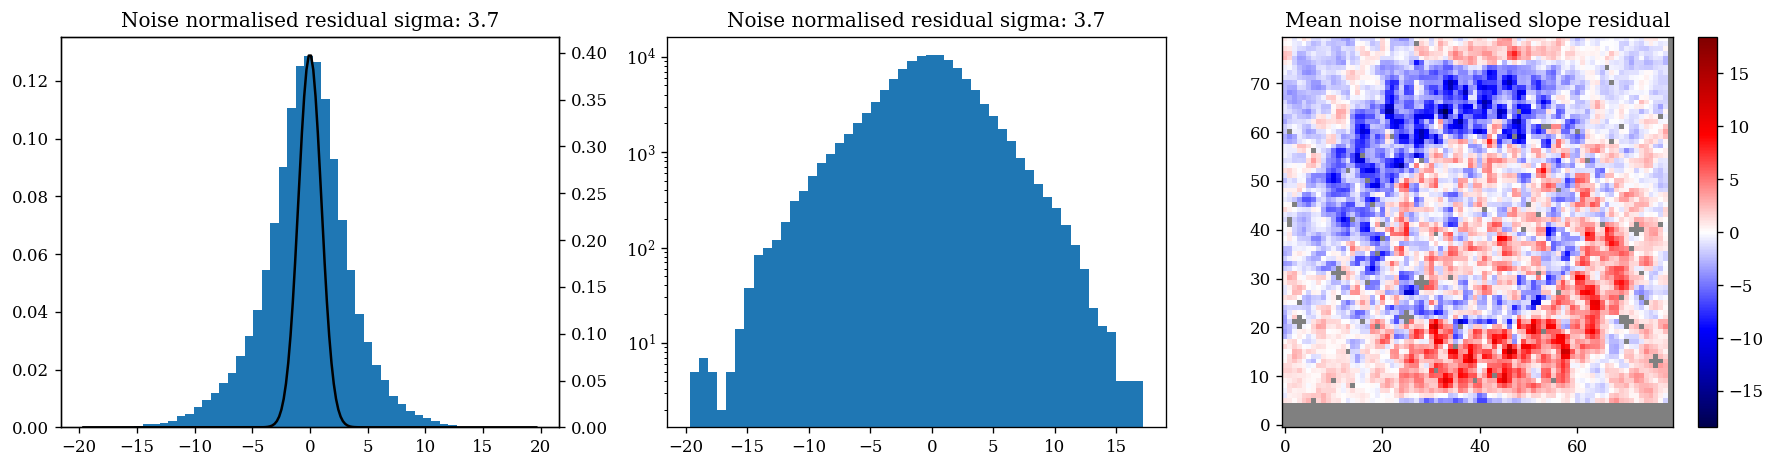

File jw04481001001_03106_00001_0001_2
Star HD-41094
Filter F430M
nints 905
ngroups 20



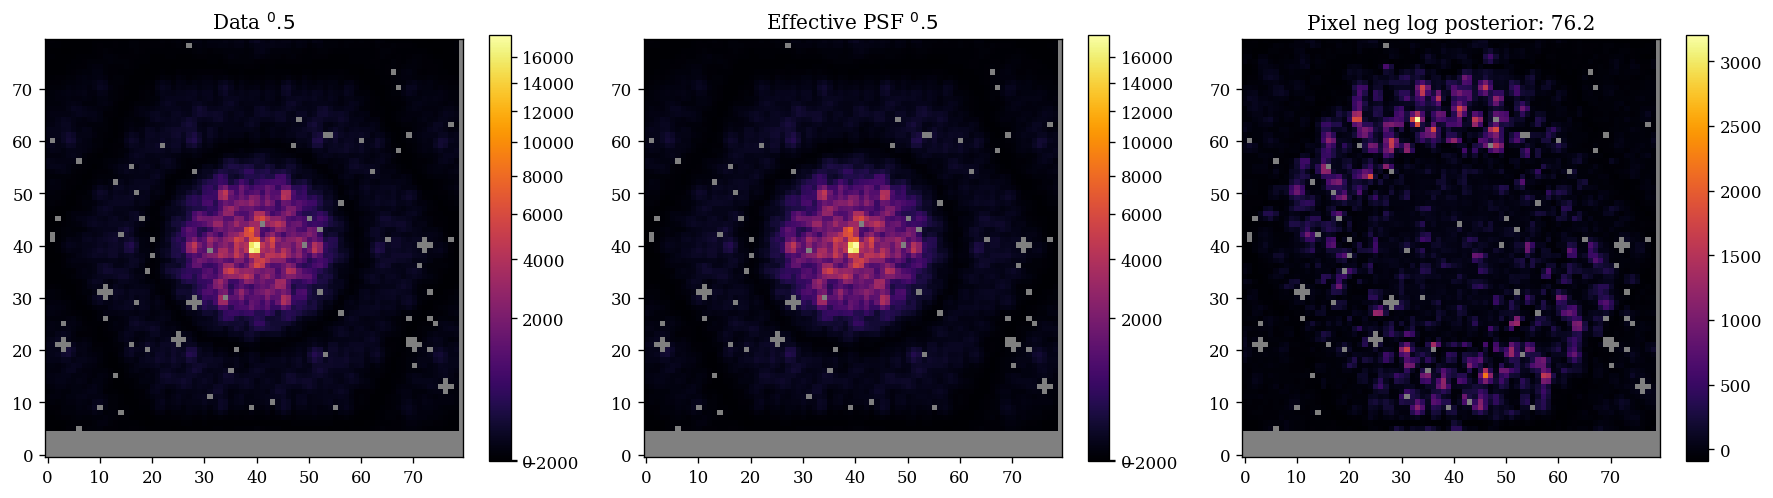

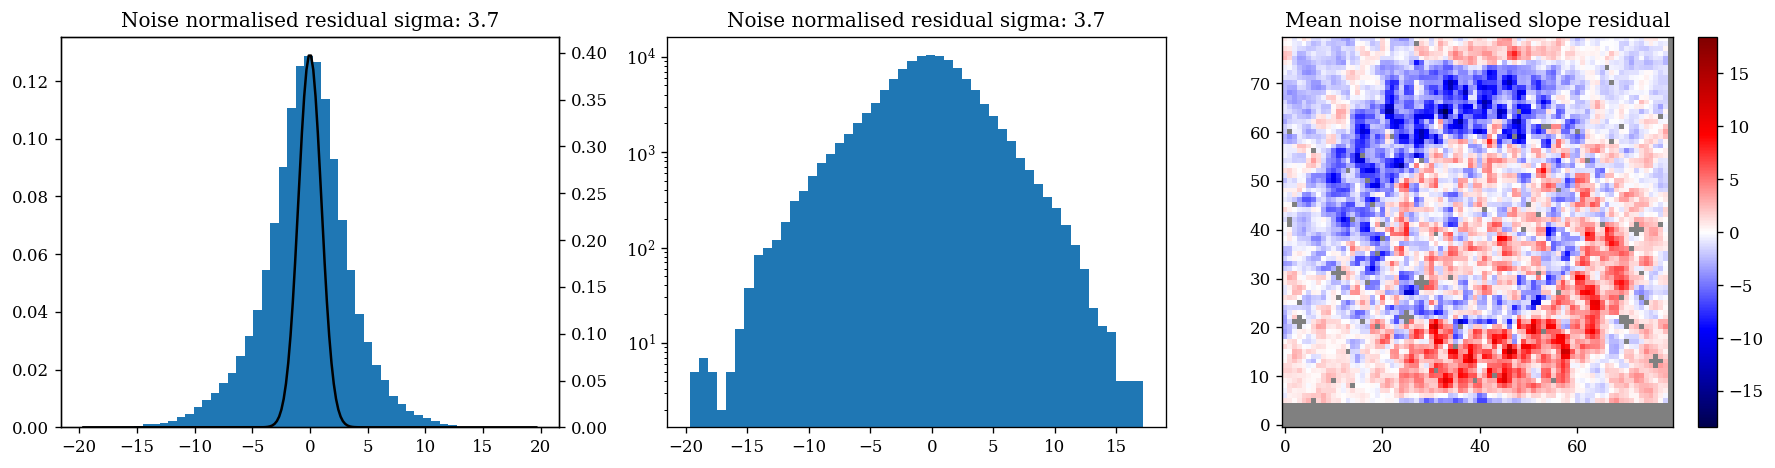

File jw04481001001_03106_00001_0001_3
Star HD-41094
Filter F430M
nints 905
ngroups 20



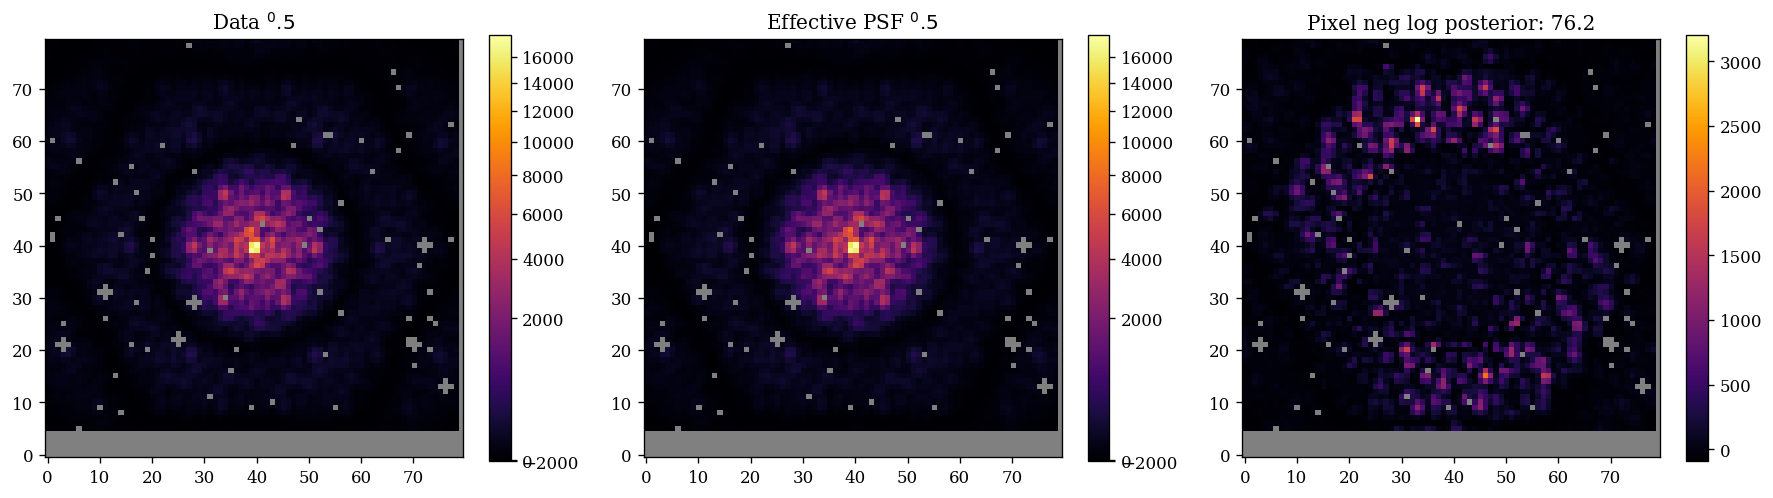

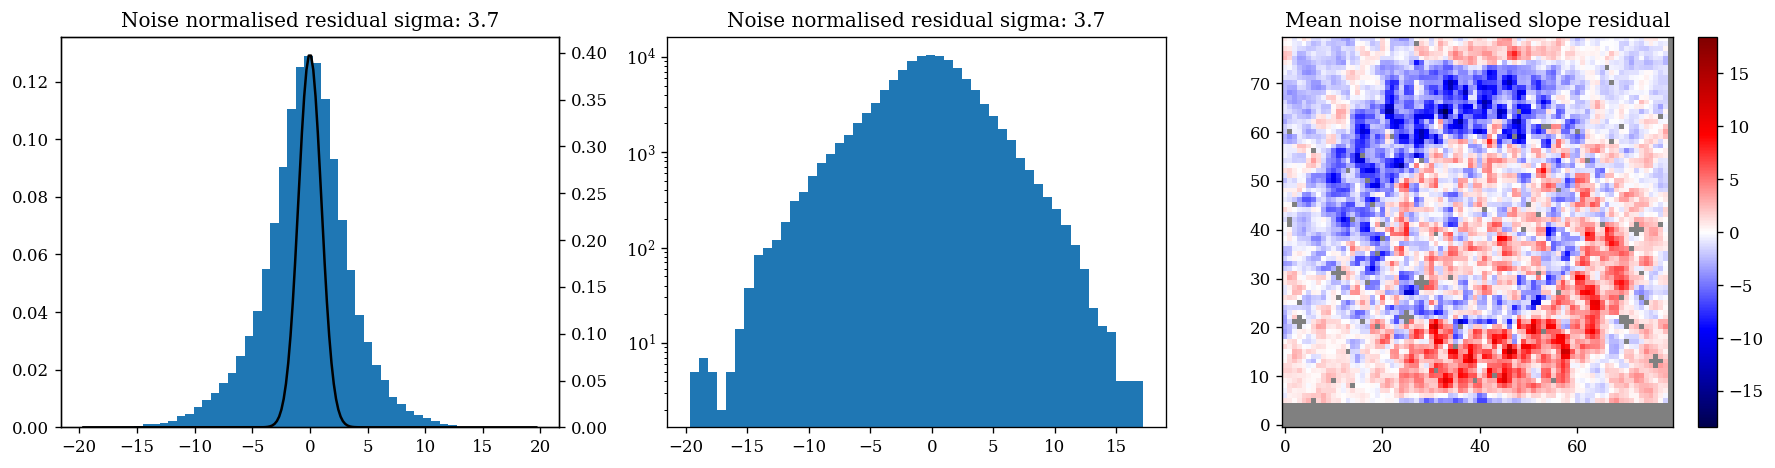

File jw04481001001_03106_00001_0001_4
Star HD-41094
Filter F430M
nints 905
ngroups 20



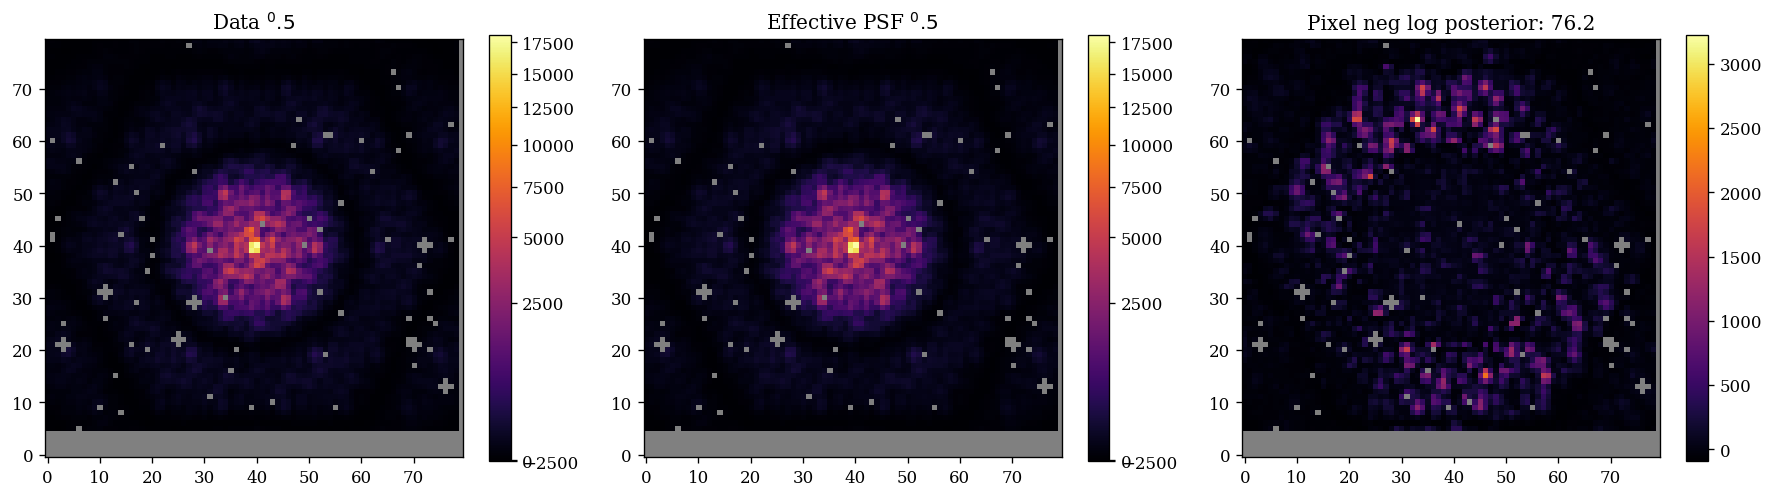

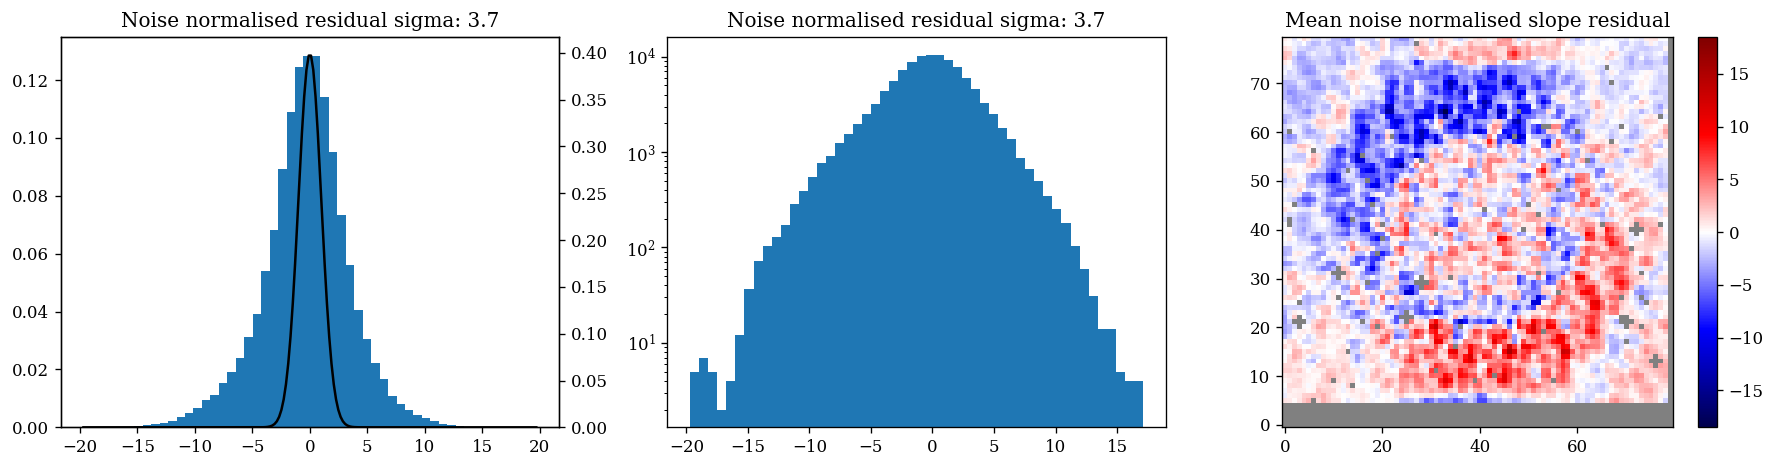

File jw04481001001_03106_00001_0001_5
Star HD-41094
Filter F430M
nints 905
ngroups 20



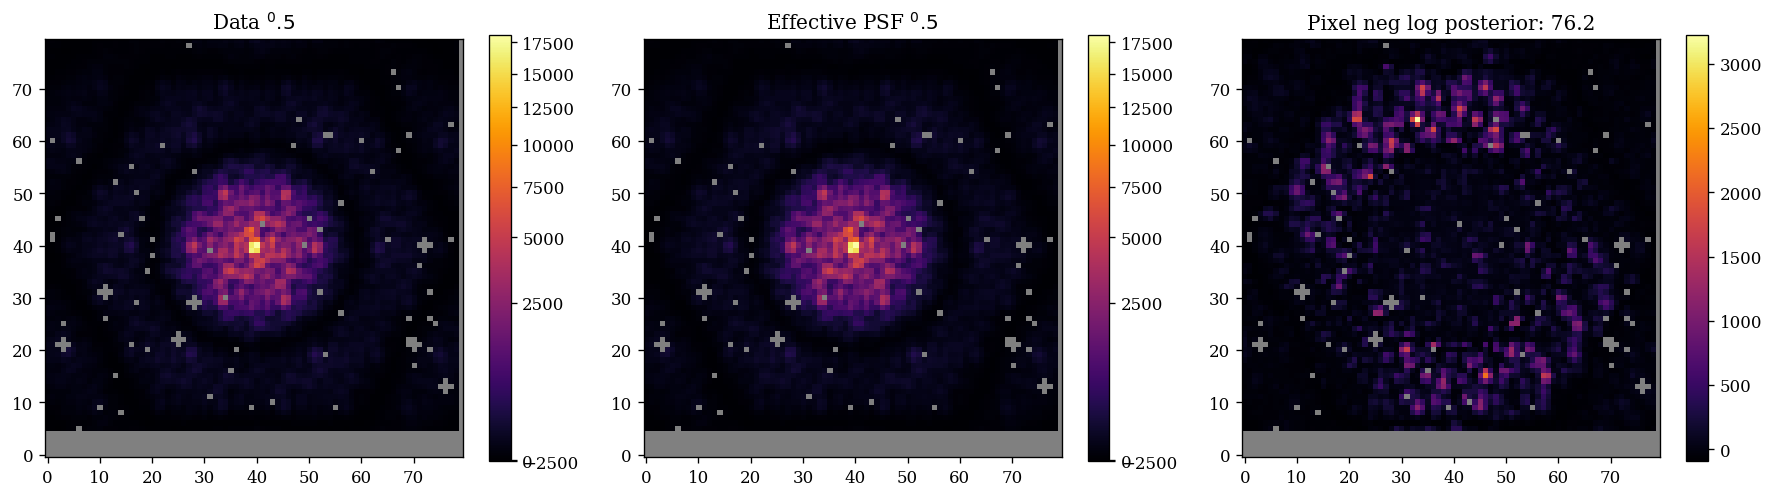

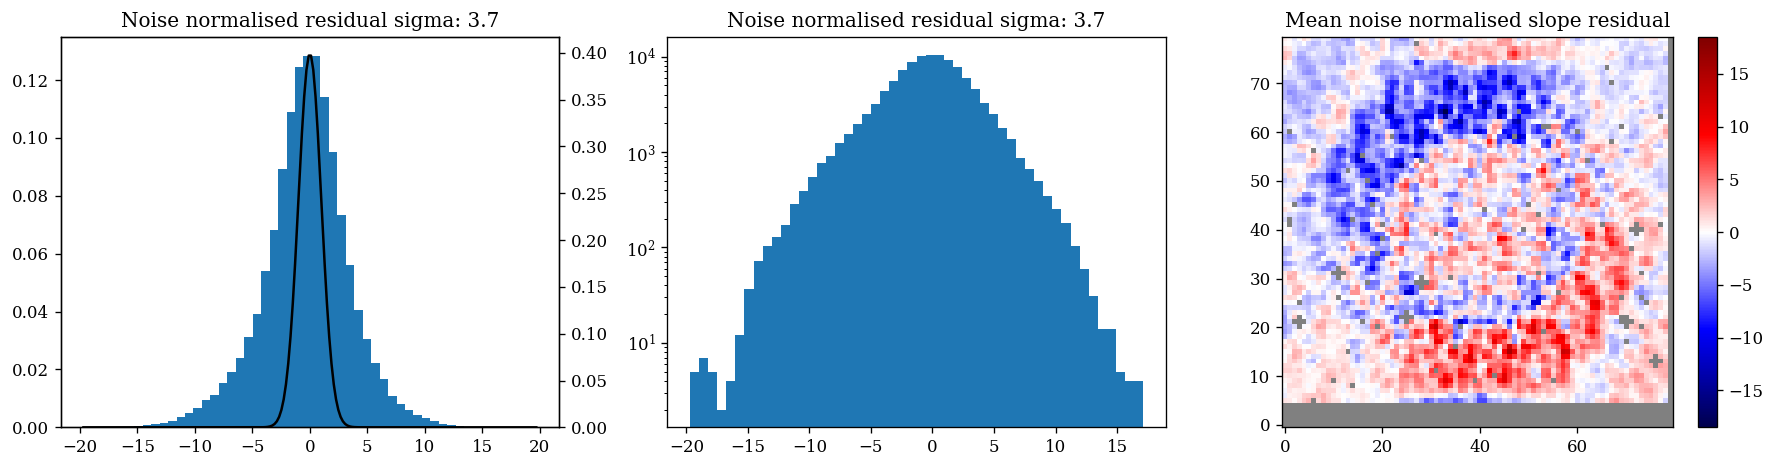

File jw04481001001_03106_00001_0001_6
Star HD-41094
Filter F430M
nints 905
ngroups 20



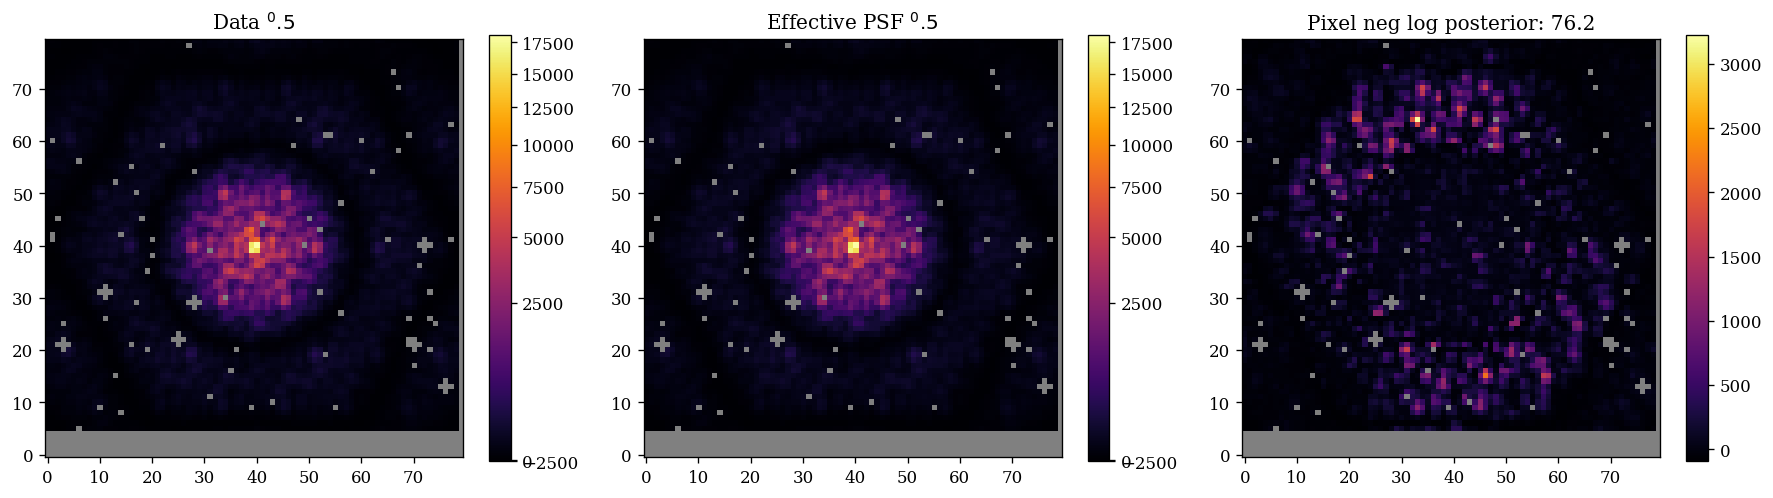

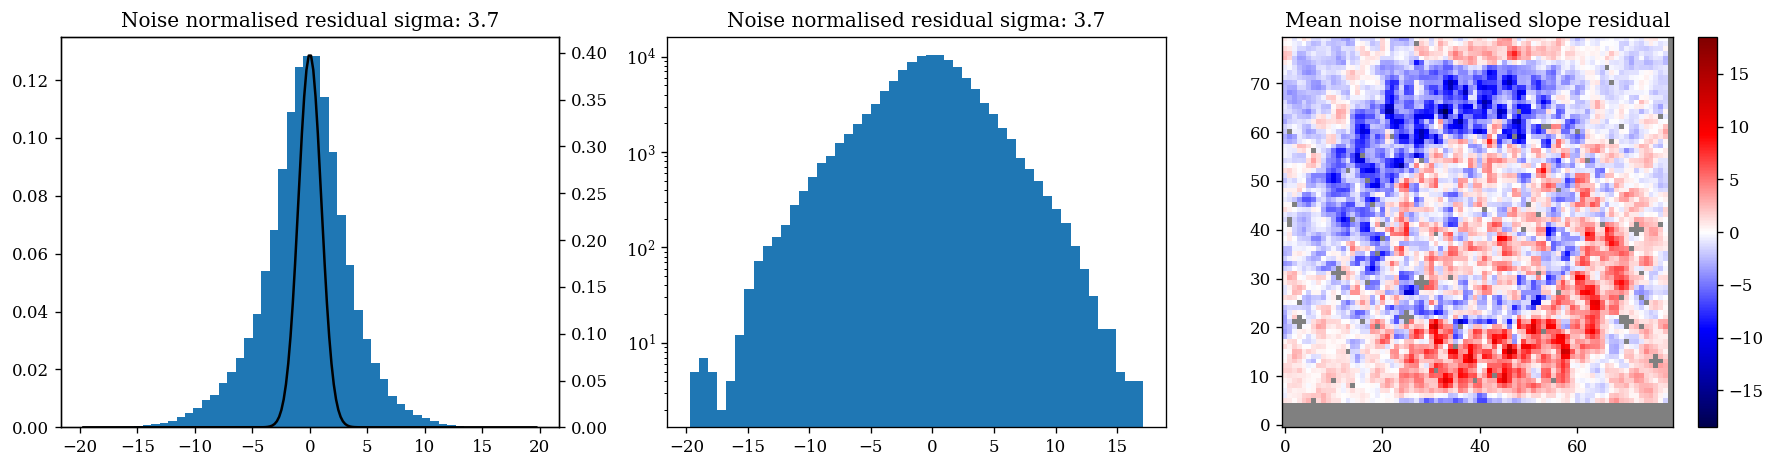

File jw04481001001_03106_00001_0001_7
Star HD-41094
Filter F430M
nints 905
ngroups 20



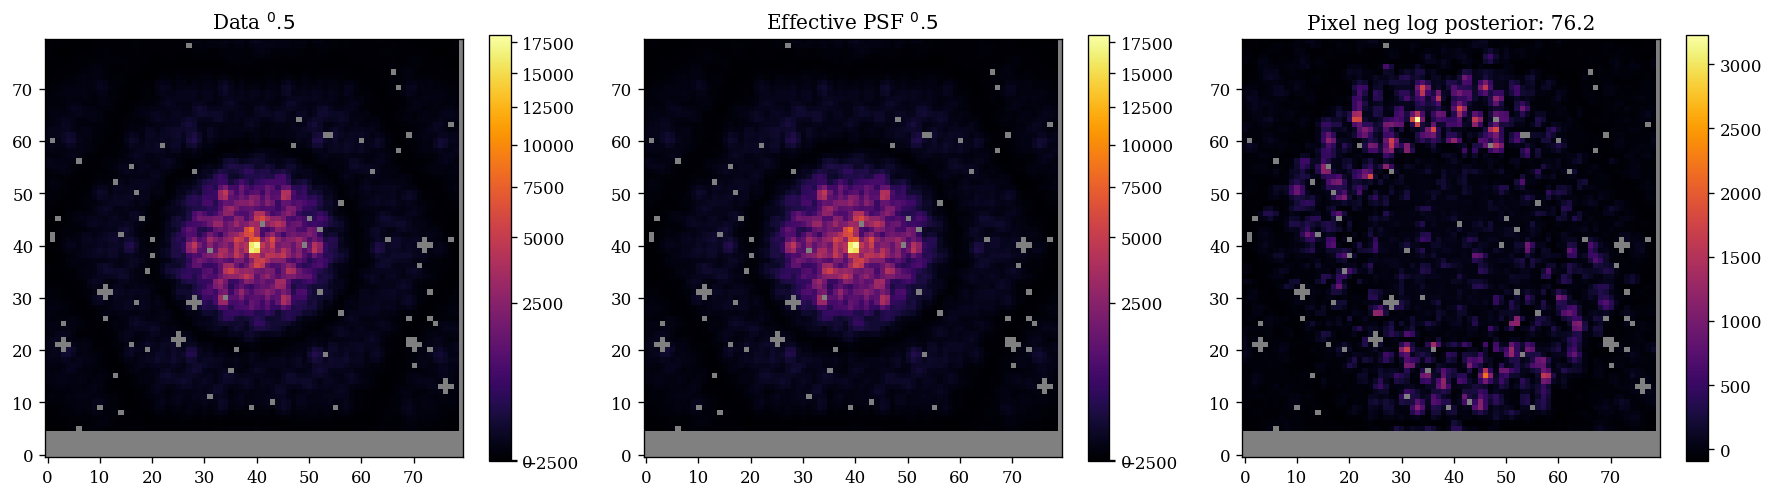

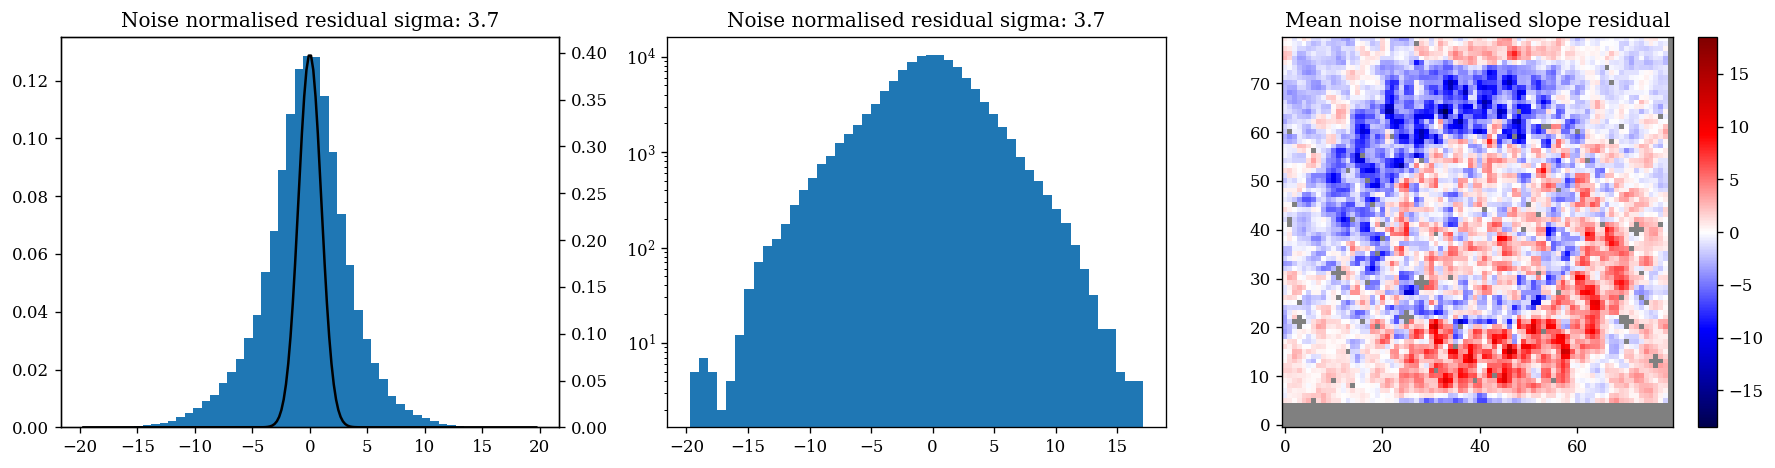

File jw04481001001_03106_00001_0001_8
Star HD-41094
Filter F430M
nints 905
ngroups 20



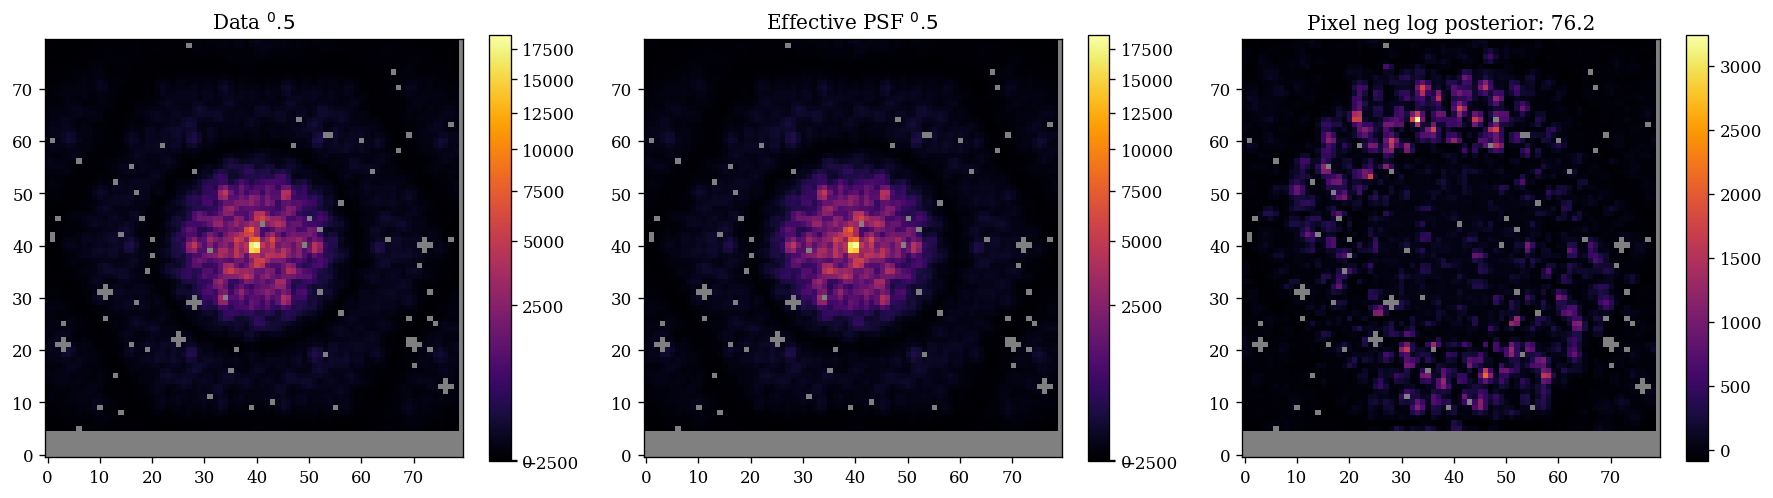

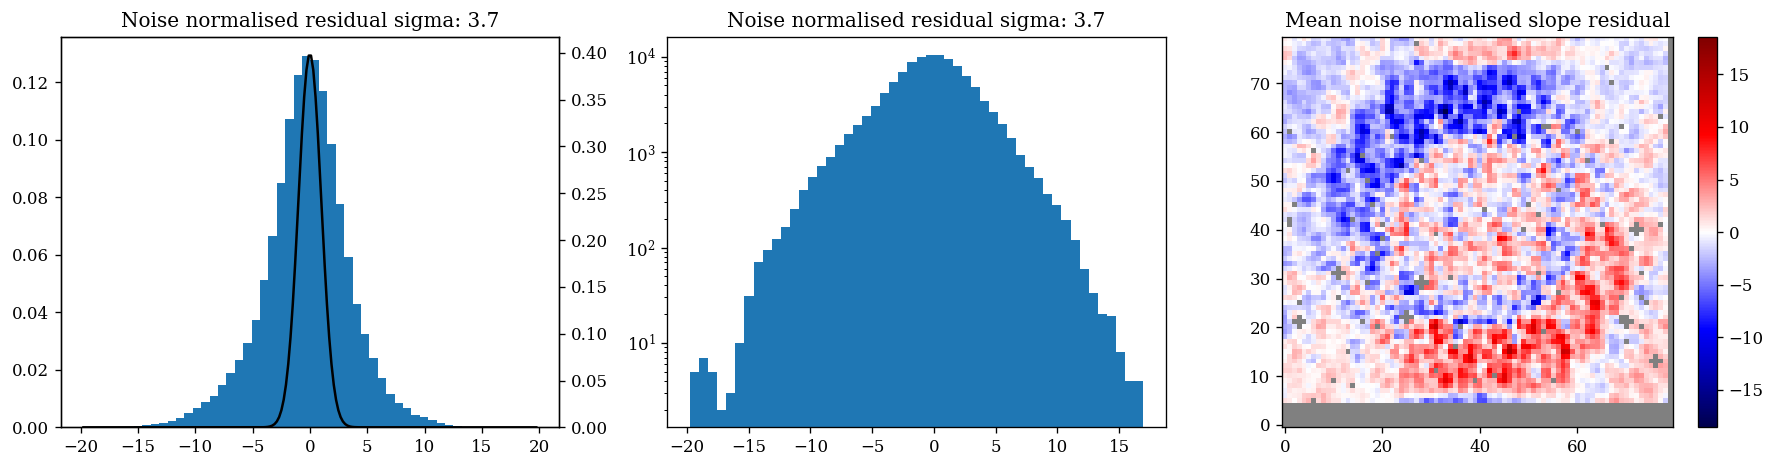

File jw04481001001_03106_00001_0001_9
Star HD-41094
Filter F430M
nints 905
ngroups 20



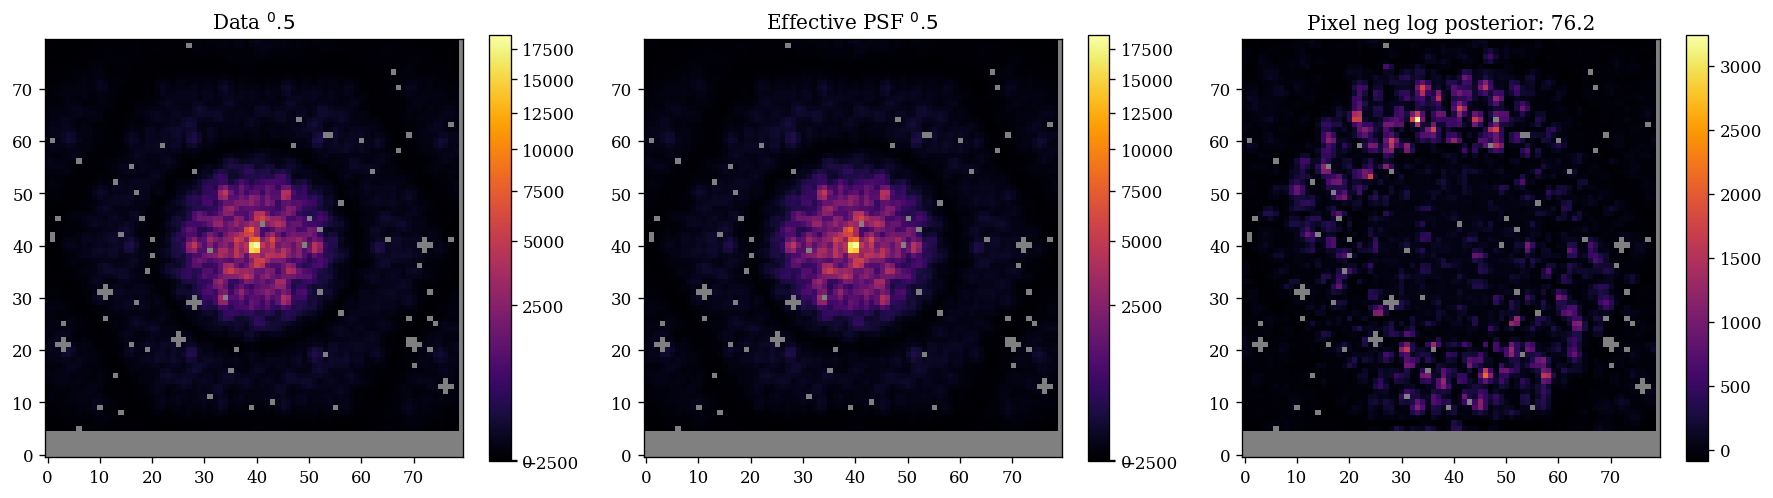

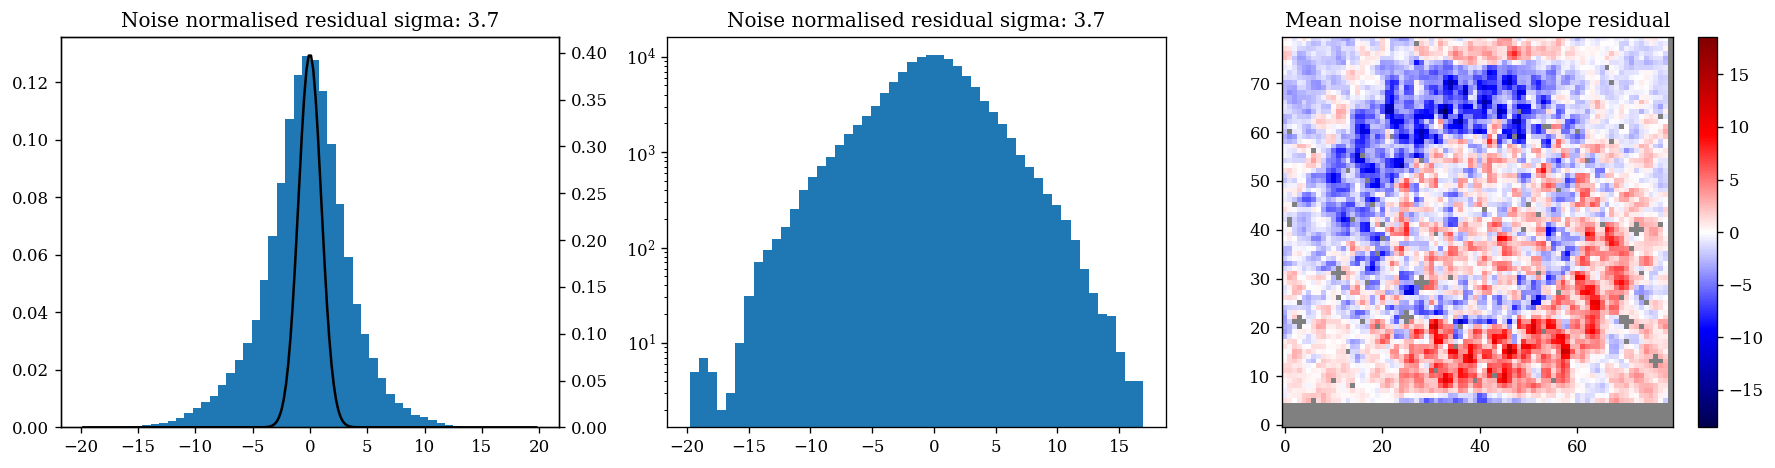

File jw04481001001_03106_00001_0001_10
Star HD-41094
Filter F430M
nints 905
ngroups 20



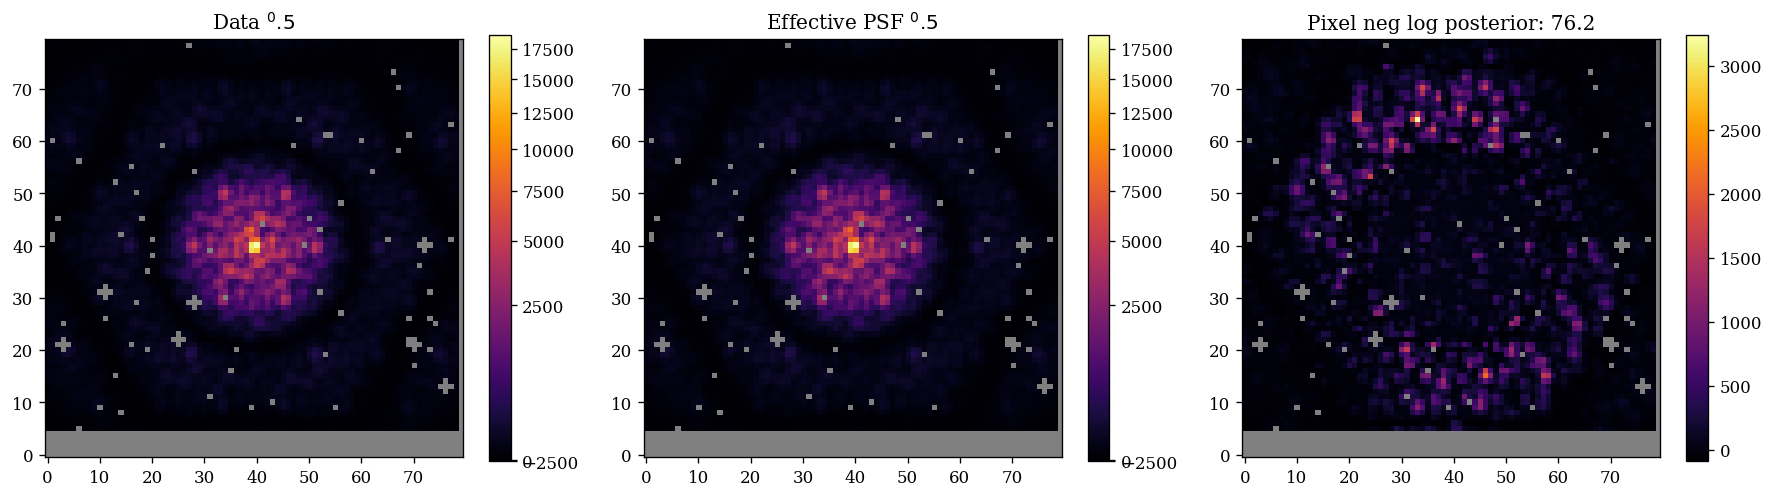

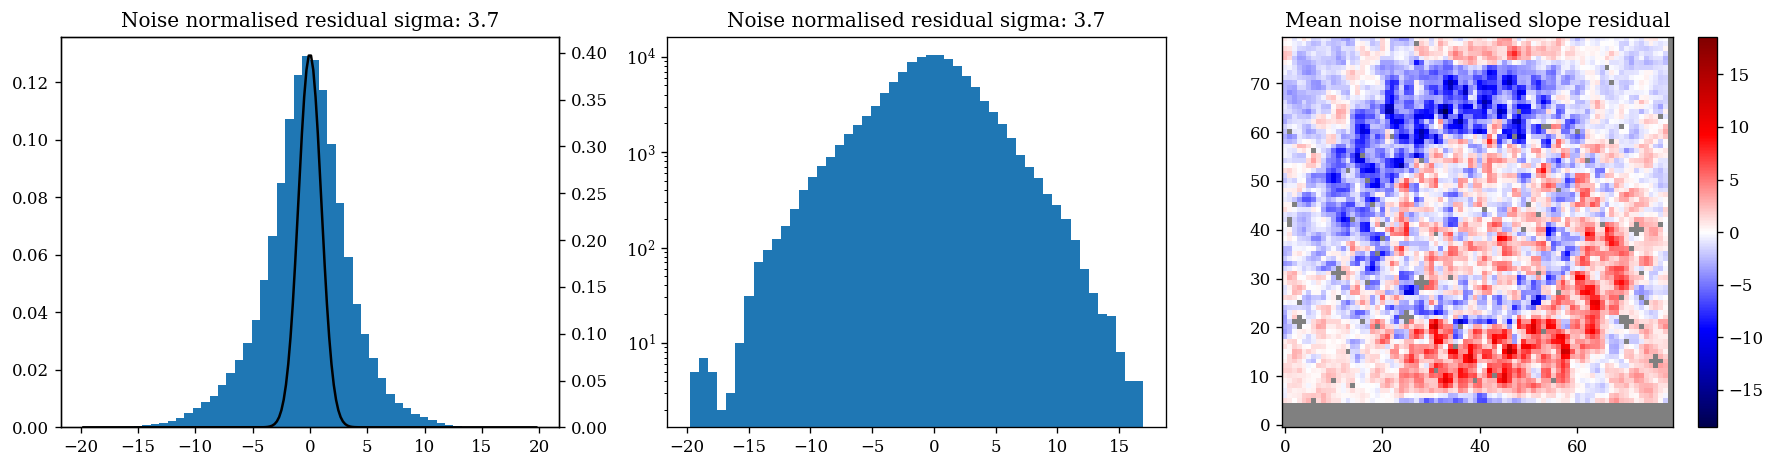

File jw04481001001_03106_00001_0001_11
Star HD-41094
Filter F430M
nints 905
ngroups 20



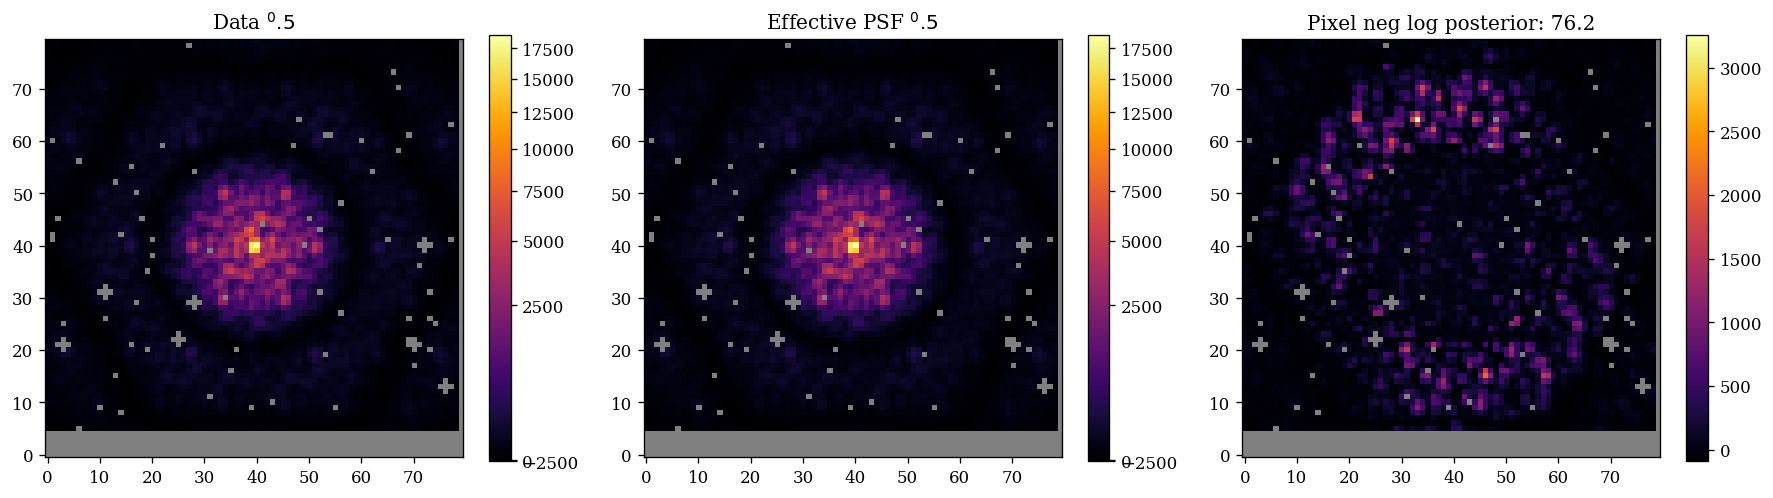

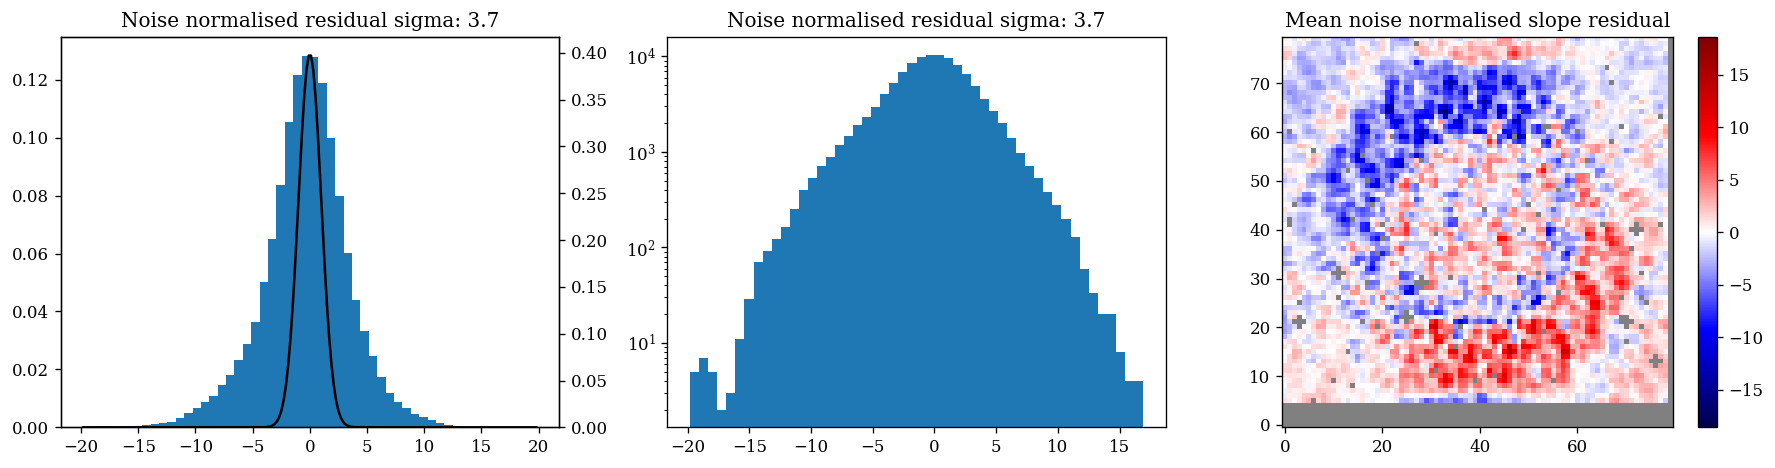

File jw04481001001_03106_00001_0001_12
Star HD-41094
Filter F430M
nints 905
ngroups 20



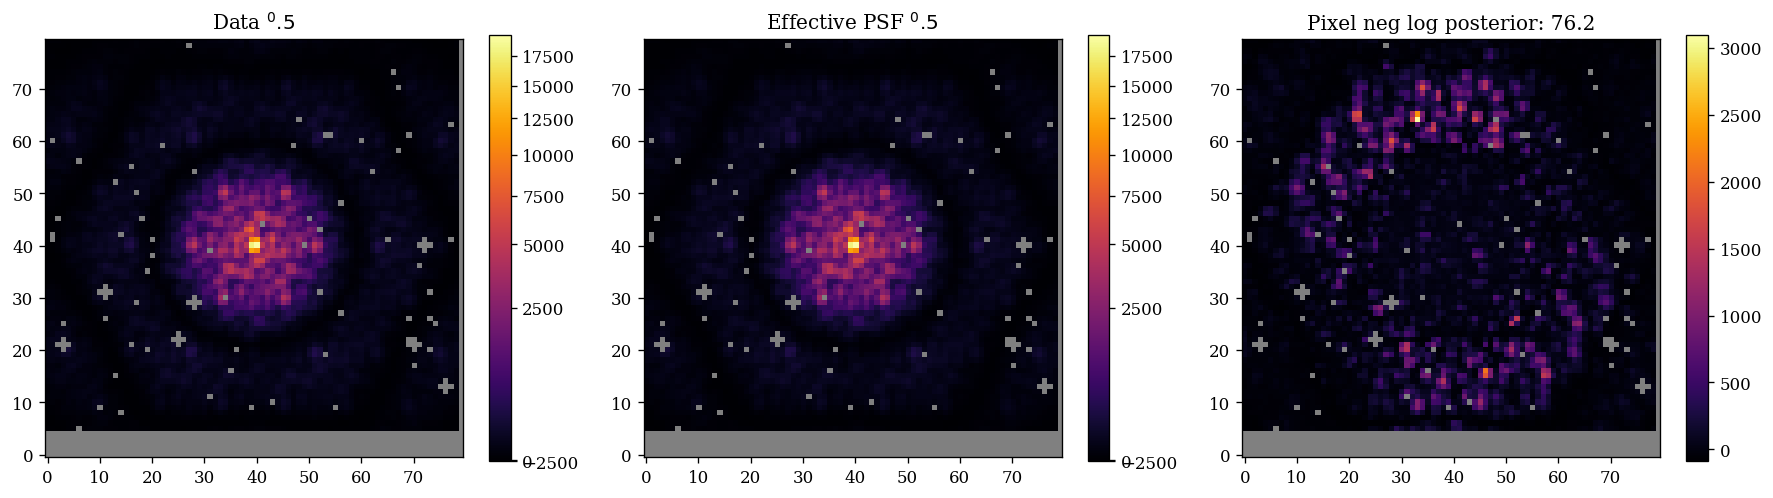

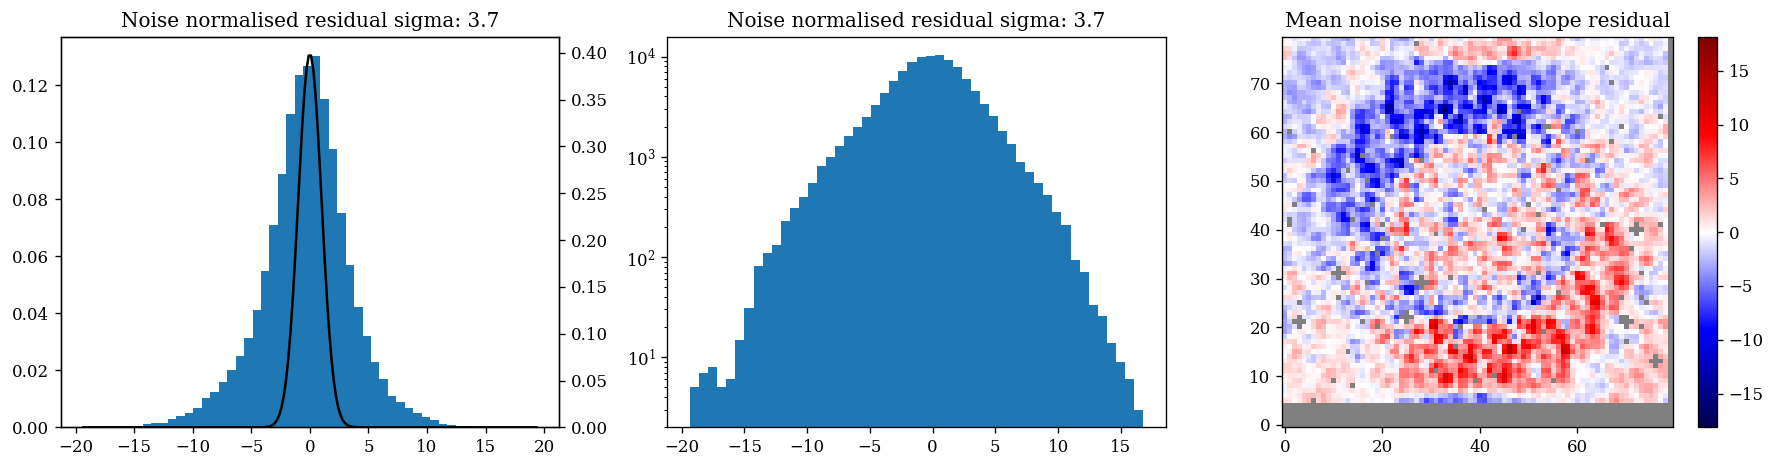

File jw04481001001_03106_00001_0001_13
Star HD-41094
Filter F430M
nints 905
ngroups 20



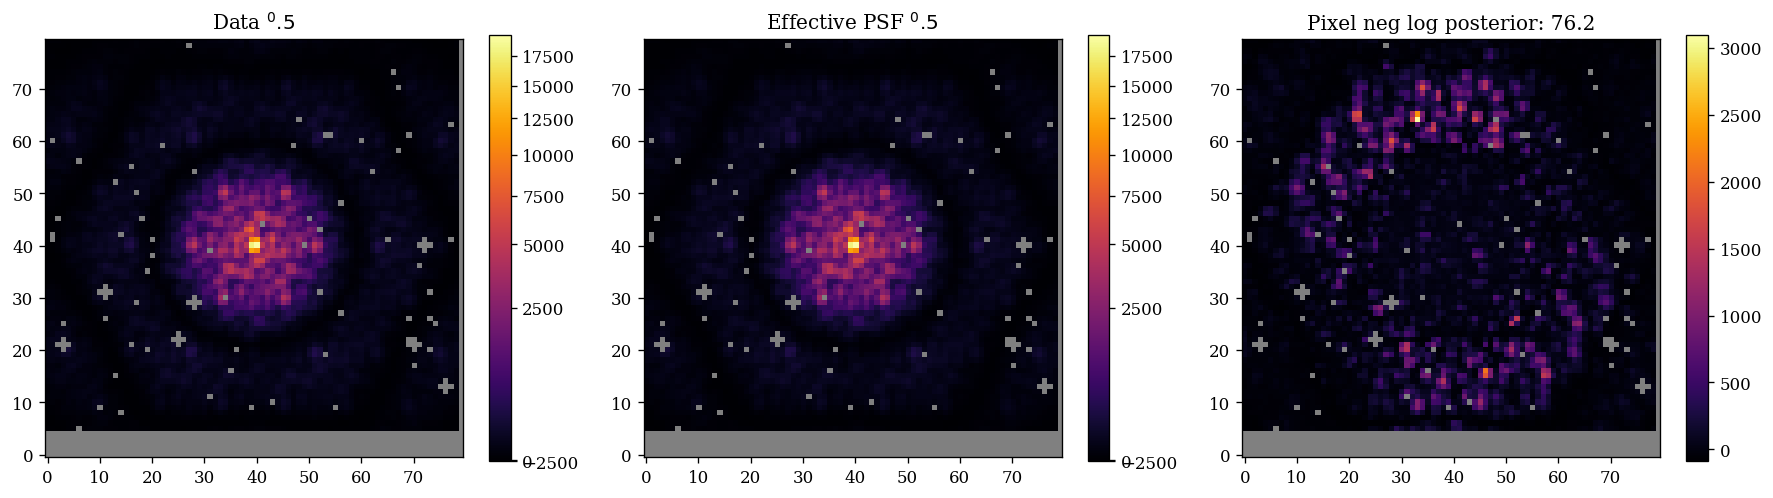

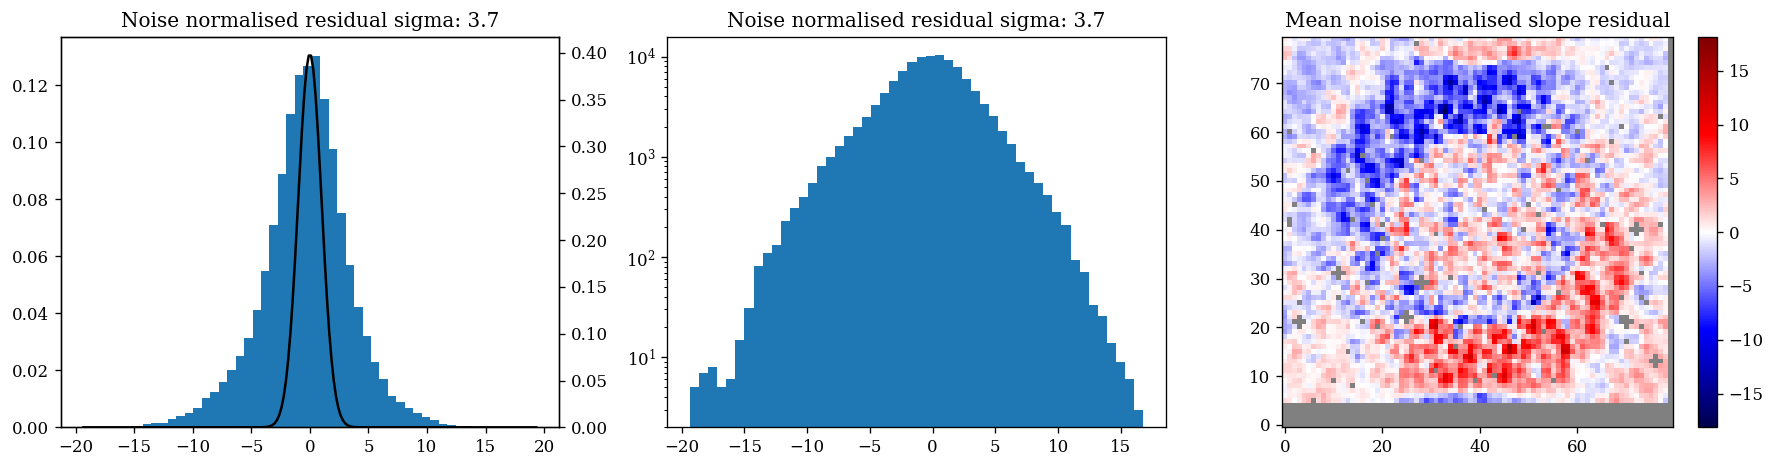

File jw04481001001_03106_00001_0001_14
Star HD-41094
Filter F430M
nints 905
ngroups 20



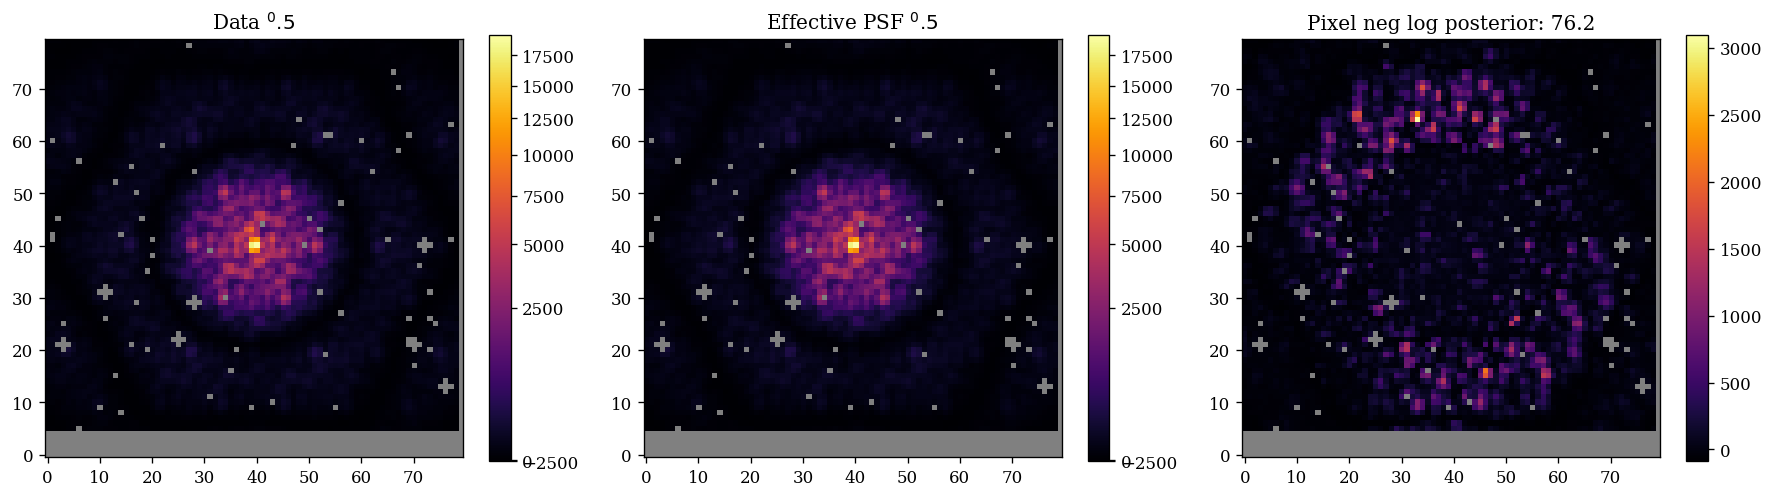

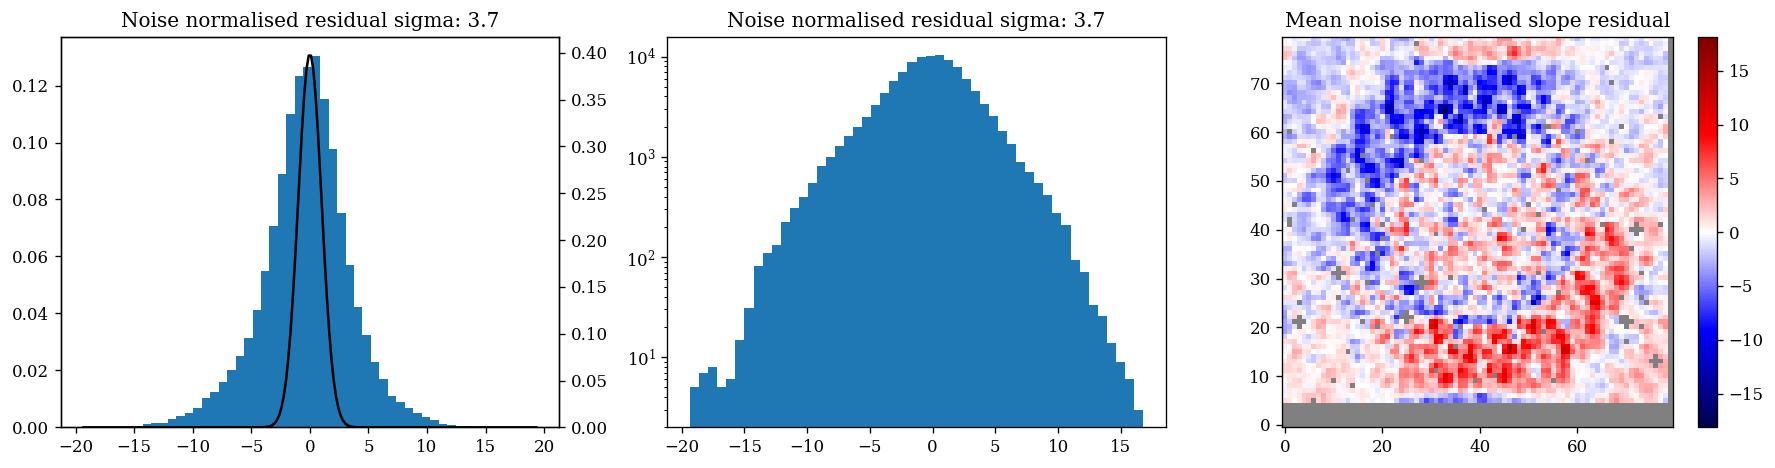

File jw04481001001_03106_00001_0001_15
Star HD-41094
Filter F430M
nints 905
ngroups 20



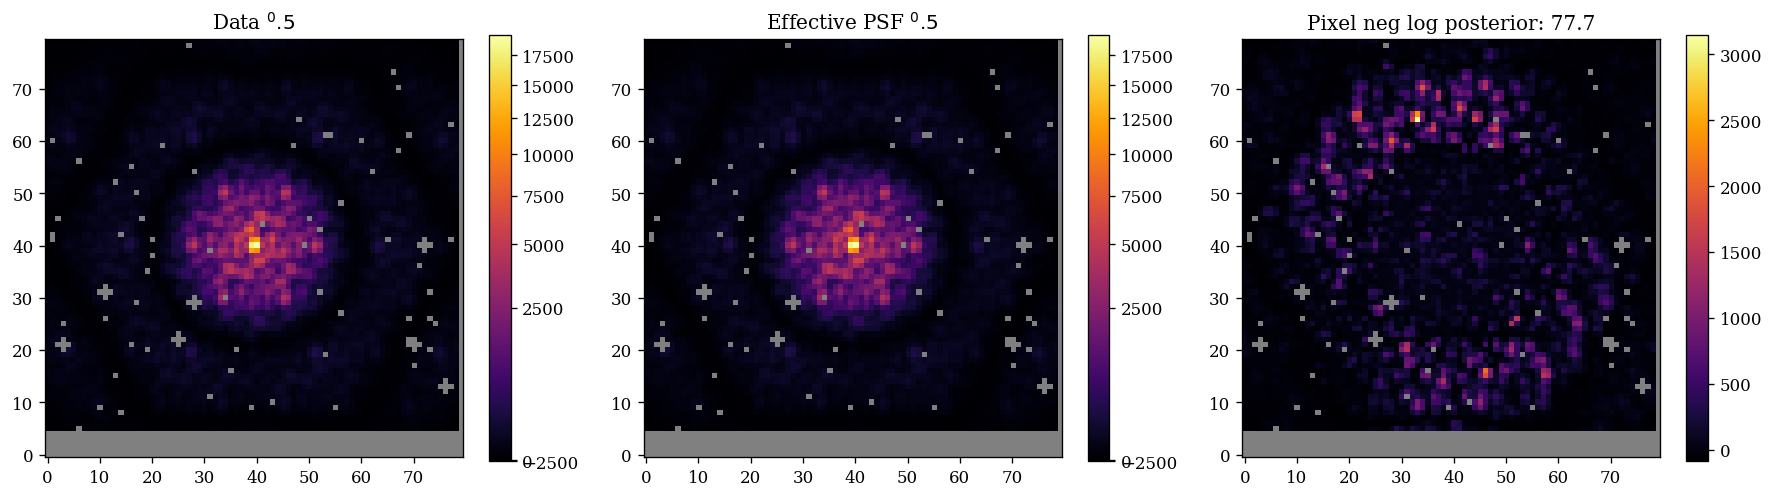

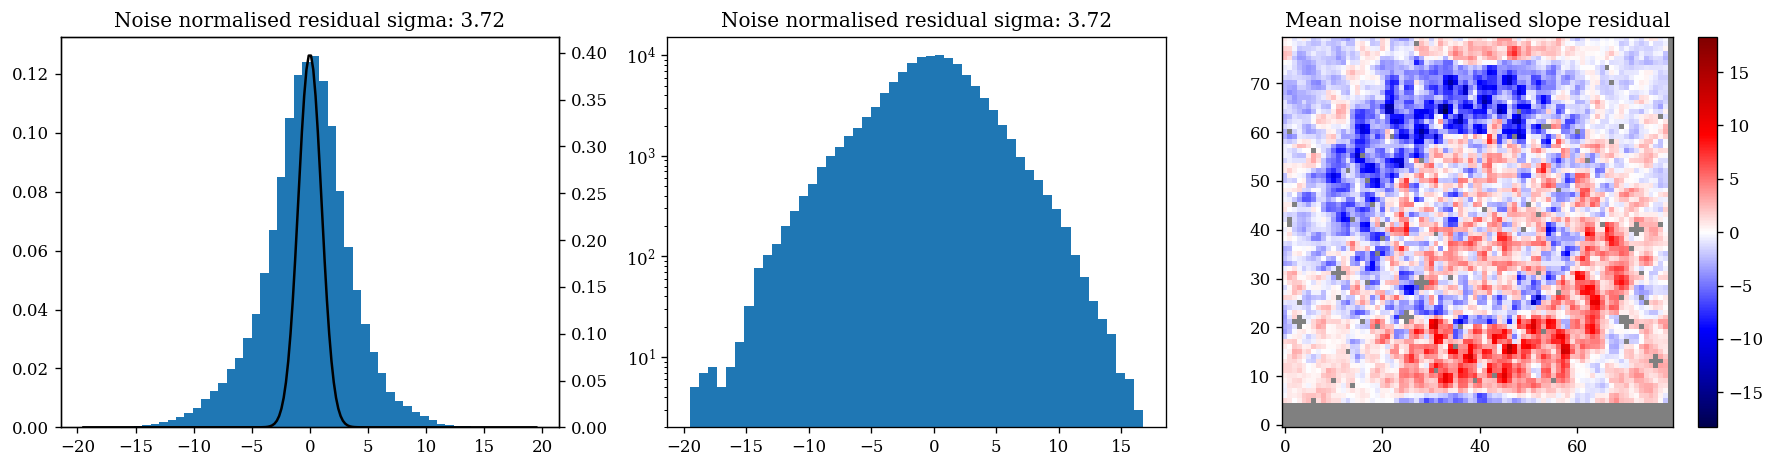

In [14]:
for exp in new_exposures:
    exp.print_summary()
    summarise_fit(
        exp, 
        final_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        # up_the_ramp_norm=True,
        # full_bias=True,
        # aberrations=True,
    )

In [15]:
for exp in exposures:
    exp.print_summary()
    psf, flux, oversample = final_model.model(exp, to_BFE=True)
    # ramp, bleed_ramp = final_model.ramp.bleeding_model(psf.data, exp.filter)
    image = psf.data * flux
    # ramp = model_ramp(image, exp.ngroups)
    ramp = model_ramp(image, 20)
    bleed_ramp = vmap(final_model.ramp.calculate_bleeding)(ramp)

    ramp_vals = (np.arange(len(bleed_ramp)) + 1) / len(bleed_ramp)
    inv_ramp = 1 / ramp_vals

    inds = [5, 10, 15, 20]
    plt.figure(figsize=(20, 4))
    plt.suptitle("Raw Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.suptitle("Normalised Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx] * inv_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

File jw04481001001_03106_00001_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



KeyError: 'jw04481001001_03106_00001_0001'

In [ ]:
np.save("files/poly_coeffs", model.ramp.coeffs)

In [ ]:
import os
from datetime import date


def create_folder():
    root_path = 'files/models/'

    # Get the current date as a string
    current_date = str(date.today())
    base_path = root_path + current_date

    # Check if a folder with the current date exists, and if not, create it
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Get a list of all directories in the current date folder
    dirs = [
        d
        for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]

    # Filter out directories that can't be converted to integers
    dirs = [d for d in dirs if d.isdigit()]

    # Convert the directory names to integers
    dirs = [int(d) for d in dirs]

    # Find the lowest integer that doesn't exist in the list
    next_int = 0
    while next_int in dirs:
        next_int += 1

    # Create a directory with the next integer
    next_dir = os.path.join(base_path, str(next_int))
    os.makedirs(next_dir)

    os.makedirs(next_dir + "/exposures/")

    return next_dir

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
from zodiax.experimental import serialise


save_path = create_folder()

# eqx.tree_serialise_leaves(f"{save_path}/CNN_BFE.eqx", final_model.BFE)
serialise(f"{save_path}/BFE", final_model.BFE)
serialise(f"{save_path}/AMI_mask", final_model.pupil_mask)
serialise(f"{save_path}/anisotropy", final_model.anisotropy)
serialise(f"{save_path}/reflectivities", final_model.optics.holes)
np.save(f"{save_path}/dark_current", final_model.detector.dark_current)


# for exp in exposures:
#     key = exp.key
# exp = exp.set('bias', model.biases[key])
# exp = exp.set('one_on_fs', model.one_on_fs[key])
# exp = exp.set('position', model.positions[key])
# exp = exp.set("aberrations", model.aberrations[key])
# exp = exp.set('flux', model.fluxes[key])
# serialise(f"{save_path}/exposures/{key}", exp)

print(save_path)

files/models/2024-04-23/0


In [ ]:
100 % -1

0